# Load data

In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

from tensorflow.keras.utils import plot_model
from utils import get_train_test_data

2021-12-29 17:00:05.107153: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
if sys.platform == "linux":
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-12-29 17:00:07.399351: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-29 17:00:08.442468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 17:00:08.443517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-12-29 17:00:08.443608: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-29 17:00:08.447340: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-12-29 17:00:08.450948: I tensorflow/stream_executor/pla

In [45]:
X_train, y_train, X_test, y_test = get_train_test_data()

id3_hook_1 reversed: False data shape: (1461, 36)
--------------------
id2_hook_2 reversed: True data shape: (1041, 36)
--------------------
id1_hook_2 reversed: True data shape: (792, 36)
--------------------
id0_hook_1 reversed: False data shape: (1100, 36)
--------------------
id2_hook_1 reversed: False data shape: (1013, 36)
--------------------
id1_hook_1 reversed: False data shape: (858, 36)
--------------------
id3_hook_2 reversed: True data shape: (1297, 36)
--------------------
id0_hook_2 reversed: True data shape: (1051, 36)
--------------------
id4_hook_2 reversed: True data shape: (1059, 36)
--------------------
id4_hook_1 reversed: False data shape: (1054, 36)
--------------------
id1_jab_2 reversed: True data shape: (643, 36)
--------------------
id3_jab_1 reversed: False data shape: (1170, 36)
--------------------
id1_jab_1 reversed: False data shape: (802, 36)
--------------------
id0_jab_2 reversed: True data shape: (993, 36)
--------------------
id4_jab_1 reversed: Fa

In [50]:
def compute_vector_angle(p0, p1, p2):
    # vector p0 - p1
    v1 = p0 - p1
    
    # vector p0 - p2
    v2 = p2 - p1
    
    v1_length = np.sqrt(v1[0] ** 2 + v1[1] ** 2)
    v2_length = np.sqrt(v2[0] ** 2 + v2[1] ** 2)
    
    cos = (v1[0] * v2[0] + v1[1] * v2[1]) / (v1_length * v2_length)
    
    if cos < -1:
        cos = -1
        
    if cos > 1:
        cos = 1

    return np.arccos(cos)


assert np.round(compute_vector_angle(np.array([2, 6]), np.array([0, 0]), np.array([8, 4])), 2) == 0.79

In [51]:
def add_angles(keypoints):
    return np.append(
        keypoints,
        [
            compute_vector_angle(keypoints[10:12], keypoints[14:16], keypoints[18:20]), # angle between left shoulder and wrist in radians
            compute_vector_angle(keypoints[12:14], keypoints[16:18], keypoints[20:22]), # angle between right shoulder and wrist in radians
        ])

In [52]:
X_train = np.apply_along_axis(add_angles, 1, X_train)
X_test = np.apply_along_axis(add_angles, 1, X_test)

In [54]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16,
    'mid_point': 17,
    'angle': 18
}


In [55]:
def format_feature_names(names):
    """"Form list of feature names

    Params:
        names - list of KEYPOINT_DICT keys
        ndims - number of dimensions (x, y, score)
        skip_midpoints - add or omit midpoint coords (x, y, score)

    Returns:
        list of feature names
    """
    feature_names = []
    for name in names:
        if 'angle' in name:
            feature_names.append(name+'-left')
            feature_names.append(name+'-right')
        else:
            feature_names.append(name+'-x')
            feature_names.append(name+'-y')

    return feature_names

In [56]:
# fix me
feature_names = format_feature_names(list(KEYPOINT_DICT.keys()))

In [57]:
df = pd.DataFrame(data=X_train, columns=feature_names)

In [58]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,27868.0,-0.220575,0.028482,-0.464482,-0.235980,-0.218050,-0.202231,0.356807
nose-y,27868.0,0.002927,0.155609,-0.668847,-0.147820,0.050110,0.143809,0.321883
left_eye-x,27868.0,-0.232863,0.029856,-0.394743,-0.249660,-0.230255,-0.213843,0.356518
left_eye-y,27868.0,0.000017,0.152740,-0.627711,-0.148423,0.047787,0.134881,0.281147
right_eye-x,27868.0,-0.233255,0.030114,-0.407856,-0.249965,-0.230466,-0.214037,0.356241
right_eye-y,27868.0,0.005944,0.151607,-0.669672,-0.137414,0.038847,0.146332,0.272068
left_ear-x,27868.0,-0.237401,0.028898,-0.474184,-0.256933,-0.235630,-0.217142,0.342778
left_ear-y,27868.0,-0.007544,0.111543,-0.630786,-0.110987,0.017184,0.082443,0.293566
right_ear-x,27868.0,-0.238082,0.030053,-0.469636,-0.256478,-0.236798,-0.217853,0.338165
right_ear-y,27868.0,0.009817,0.110426,-0.600944,-0.079575,-0.003794,0.115508,0.307987


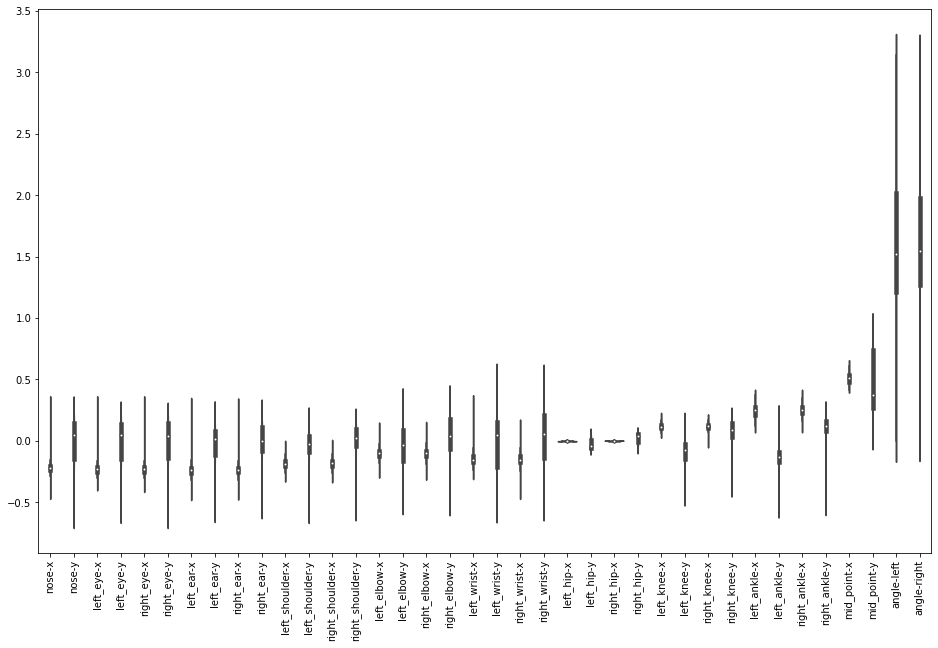

In [59]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [60]:
time_steps=30 # expect camera 30 fps, so process 1 sample per second
# Number of samples in batch
N_train = X_train.shape[0] // time_steps 
N_val = X_test.shape[0] // time_steps

In [61]:
X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 38)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)
X_test = X_test[:N_val*time_steps].reshape(-1, time_steps, 38)
y_test = y_test[:N_val*time_steps].reshape(-1, time_steps, 1)
X_train.shape, X_test.shape

((928, 30, 38), (106, 30, 38))

## GRU

In [62]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)
y_test = K.utils.to_categorical(y_test, num_classes=7)
X_test = tf.constant(X_test)

In [69]:
def model_builder(hp):
    # Hyperparams
    hp_ru1 = hp.Int('recurrent_units', min_value=16, max_value=128, step=8)
    hp_ru2 = hp.Int('recurrent_units', min_value=16, max_value=128, step=8)

    hp_du1 = hp.Int('units1', min_value=16, max_value=128, step=8)
    hp_du2 = hp.Int('units2', min_value=16, max_value=128, step=8)

    hp_reg1 = hp.Float('dense1_reg', min_value=1e-4, max_value=1e-2)
    hp_reg2 = hp.Float('dense2_reg', min_value=1e-4, max_value=1e-2)
    
    hp_dp1 = hp.Float('dropout', min_value=0., max_value=0.4)
    hp_dp2 = hp.Float('dropout', min_value=0., max_value=0.4)

    hp_dl_dp = hp.Float('dropout', min_value=0., max_value=0.4)

    hp_rec_dp1 = hp.Float('rec_dropout', min_value=0., max_value=0.4)
    hp_rec_dp2 = hp.Float('rec_dropout', min_value=0., max_value=0.4)

    hp_kernel_reg1 = hp.Float('kernel_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_kernel_reg2 = hp.Float('kernel_reg', min_value=1e-5, max_value=1e-3, sampling='log')

    hp_recur_reg1 = hp.Float('recur_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_recur_reg2 = hp.Float('recur_reg', min_value=1e-5, max_value=1e-3, sampling='log')

    hp_act_reg1 = hp.Float('act_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_act_reg2 = hp.Float('act_reg', min_value=1e-5, max_value=1e-3, sampling='log')
 
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    layers = []
    
    # Model
    norm = tf.keras.layers.LayerNormalization(axis=1)
    layers.append(norm)

    kernel_reg1 = K.regularizers.l2(hp_kernel_reg1)
    kernel_reg2 = K.regularizers.l2(hp_kernel_reg2)

    recurrent_reg1 = K.regularizers.l2(hp_recur_reg1)
    recurrent_reg2 = K.regularizers.l2(hp_recur_reg2)

    act_reg1 = K.regularizers.l2(hp_act_reg1)
    act_reg2 = K.regularizers.l2(hp_act_reg2)
    
    gru1 = K.layers.GRU(hp_ru1,
                         # stateful=True, # mutable states not supported in tflite 
                         return_sequences=True,
                         kernel_regularizer=kernel_reg1,
                         recurrent_regularizer=recurrent_reg1,
                         activity_regularizer=act_reg1,
                         dropout=hp_dp1,
                         recurrent_dropout=hp_rec_dp1
                        )
    layers.append(gru1)
    
    gru2 = K.layers.GRU(hp_ru2,
                         # stateful=True, # mutable states not supported in tflite 
                         return_sequences=True,
                         kernel_regularizer=kernel_reg2,
                         recurrent_regularizer=recurrent_reg2,
                         activity_regularizer=act_reg2,
                         dropout=hp_dp2,
                         recurrent_dropout=hp_rec_dp2
                        )
    layers.append(gru2)


    # add another gru layer (optional)
    dense1 = K.layers.Dense(hp_du1, activation='relu', 
                            kernel_regularizer=K.regularizers.l2(hp_reg1))
    layers.append(dense1)
    dropout = K.layers.Dropout(hp_dl_dp)
    layers.append(dropout)
    dense2 = K.layers.Dense(hp_du2, activation='relu', 
                           kernel_regularizer=K.regularizers.l2(hp_reg2))
    layers.append(dense2)
    out = K.layers.Dense(7, activation='sigmoid')
    layers.append(out)

    model = K.Sequential(layers)
    model.compile(optimizer=K.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [70]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='kt_dir2',
                     project_name='punch_dl_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

tuner.search(X_train, y_train, batch_size=1, validation_data=(X_test, y_test), 
             epochs=32, shuffle=False, callbacks=[stop_early])

Trial 31 Complete [00h 15m 54s]
val_accuracy: 0.5210691690444946

Best val_accuracy So Far: 0.5934523940086365
Total elapsed time: 01h 41m 07s
INFO:tensorflow:Oracle triggered exit


In [71]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'recurrent_units': 96,
 'units1': 48,
 'units2': 32,
 'dense1_reg': 0.006069849636292963,
 'dense2_reg': 0.005576739517497431,
 'dropout': 0.061932823067609145,
 'rec_dropout': 0.3275448528653617,
 'kernel_reg': 5.8444760669735064e-05,
 'recur_reg': 1.0864567973193044e-05,
 'act_reg': 0.00019361428090391481,
 'learning_rate': 0.005775950097089433,
 'tuner/epochs': 7,
 'tuner/initial_epoch': 3,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': 'c4571d9573c112a98cafeacada16124a'}

In [74]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)

In [77]:
history = model.fit(X_train, y_train, batch_size=1, 
                    validation_data=(X_test, y_test), 
                    epochs=64,
                    shuffle=False,
                    callbacks=[K.callbacks.ReduceLROnPlateau()])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/64

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

928/928 [==============================] - 85s 92ms/step - loss: 1.5201 - accuracy: 0.5268 - val_loss: 1.5304 - val_accuracy: 0.5286
Epoch 2/64
928/928 [==============================] - 84s 91ms/step - loss: 1.2400 - accuracy: 0.6137 - val_loss: 1.3133 - val_accuracy: 0.5535
Epoch 3/64
928/928 [==============================] - 85s 92ms/step - loss: 1.1428 - accuracy: 0.6337 - val_loss: 1.3951 - val_accuracy: 0.5535
Epoch 4/64
928/928 [==============================] - 85s 91ms/step - loss: 

928/928 [==============================] - 84s 91ms/step - loss: 0.7225 - accuracy: 0.7486 - val_loss: 1.4435 - val_accuracy: 0.5547
Epoch 53/64
928/928 [==============================] - 84s 91ms/step - loss: 0.7185 - accuracy: 0.7536 - val_loss: 1.4436 - val_accuracy: 0.5547
Epoch 54/64
928/928 [==============================] - 115s 124ms/step - loss: 0.7213 - accuracy: 0.7511 - val_loss: 1.4436 - val_accuracy: 0.5547
Epoch 55/64
928/928 [==============================] - 141s 152ms/step - loss: 0.7174 - accuracy: 0.7552 - val_loss: 1.4437 - val_accuracy: 0.5547
Epoch 56/64
928/928 [==============================] - 139s 149ms/step - loss: 0.7179 - accuracy: 0.7553 - val_loss: 1.4439 - val_accuracy: 0.5547
Epoch 57/64
928/928 [==============================] - 140s 151ms/step - loss: 0.7229 - accuracy: 0.7538 - val_loss: 1.4439 - val_accuracy: 0.5547
Epoch 58/64
928/928 [==============================] - 143s 154ms/step - loss: 0.7177 - accuracy: 0.7528 - val_loss: 1.4439 - val_accu

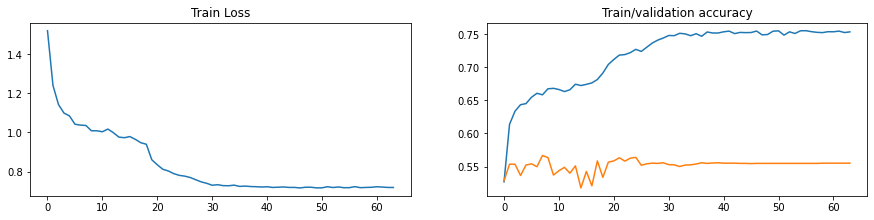

In [78]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Conclusion 

We need more data to avoid overfitting

# Convert the model

In [79]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 

tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-12-30 01:19:40.085734: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpnasd65st/assets


2021-12-30 01:19:52.880575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 01:19:52.881447: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-30 01:19:52.881612: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-12-30 01:19:52.882778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 01:19:52.883600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-12-30 01:19:52.8

ConverterError: /home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:1073:0: error: 'tf.Cast' op is neither a custom op nor a flex op
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:1167:0: note: called from
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/tensorflow/lite/python/lite.py:804:0: note: called from
/tmp/ipykernel_39818/3380019383.py:3:0: note: called from
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441:0: note: called from
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361:0: note: called from
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169:0: note: called from
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/IPython/core/async_helpers.py:68:0: note: called from
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2944:0: note: called from
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2898:0: note: called from
/home/andrew/.virtualenvs/opencv-env/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:1073:0: note: see current operation: %0 = "tf.Cast"(%arg0) {Truncate = false, device = ""} : (tensor<1x30x38xf64>) -> tensor<1x30x38xf32>
<unknown>:0: error: failed while converting: 'main': Ops that can be supported by the flex runtime (enabled via setting the -emit-select-tf-ops flag):
	tf.Cast {Truncate = false, device = ""}
<unknown>:0: note: see current operation: "func"() ( {
^bb0(%arg0: tensor<1x30x38xf64>):  // no predecessors
  %cst = "std.constant"() {value = dense<[0.320646793, -0.0589617714, -0.0758103579, -0.0487761497, -0.0618454814, -0.028024327, -0.0190065019, 0.310968161, -0.00120482175, -0.0440399833, -0.0043320288, -0.0787886828, 0.242589116, -0.0107848039, 0.275520384, -0.0148215936, -0.0685523599, -0.0414861627, -0.045816306, -2.305590e-02, 0.152567521, -0.0577774122, -6.902790e-02, -0.0726392791, -0.11261005, -0.0200380888, -0.034077581, -0.0177211165, -0.103951223, 0.257876366, 0.249684274, -0.0726607739, -0.0794425606, -0.0545503907, -0.0222450066, -0.085535258, -0.0271047819, -0.0199340452, 0.218171775, -0.0452038944, -0.0359534174, -0.0756945238, -0.0885379537, -0.0988554432, 0.219374448, -0.0793754234, -0.0285601541, 0.180237204]> : tensor<48xf32>} : () -> tensor<48xf32>
  %cst_0 = "std.constant"() {value = dense<[30, 96]> : tensor<2xi32>} : () -> tensor<2xi32>
  %cst_1 = "std.constant"() {value = dense<[1, 30, 48]> : tensor<3xi32>} : () -> tensor<3xi32>
  %cst_2 = "std.constant"() {value = dense<[-0.00144664827, 0.265289336, -0.0408265851, 0.0723766908, -0.00902843941, 0.0473236479, -0.0588233881, -0.104913332, 0.241626009, -0.0623491928, 0.0387306586, -0.0376932546, -0.0230073333, -0.102515295, 0.37367788, -0.092618838, -0.0401889645, -0.0270245727, 0.239242315, -0.00836364646, 0.742814123, -0.0139260059, 0.0466956049, 0.0320414603, -0.0750768482, -0.0835978165, -0.0134532619, 0.496960461, -0.0141358459, -0.00630991627, -0.0977091342, -0.0657331795]> : tensor<32xf32>} : () -> tensor<32xf32>
  %cst_3 = "std.constant"() {value = dense<[30, 48]> : tensor<2xi32>} : () -> tensor<2xi32>
  %cst_4 = "std.constant"() {value = dense<[1, 30, 32]> : tensor<3xi32>} : () -> tensor<3xi32>
  %cst_5 = "std.constant"() {value = dense<[-1.47610307, -1.58361554, -1.1644938, -0.667482734, -0.694524466, -0.181042492, 0.315954447]> : tensor<7xf32>} : () -> tensor<7xf32>
  %cst_6 = "std.constant"() {value = dense<[30, 32]> : tensor<2xi32>} : () -> tensor<2xi32>
  %cst_7 = "std.constant"() {value = dense<[1, 30, 7]> : tensor<3xi32>} : () -> tensor<3xi32>
  %cst_8 = "std.constant"() {value = dense<30> : tensor<i32>} : () -> tensor<i32>
  %cst_9 = "std.constant"() {value = dense<0> : tensor<i32>} : () -> tensor<i32>
  %cst_10 = "std.constant"() {value = dense<0.000000e+00> : tensor<1x96xf32>} : () -> tensor<1x96xf32>
  %cst_11 = "std.constant"() {value = dense<1.000000e-03> : tensor<f32>} : () -> tensor<f32>
  %cst_12 = "std.constant"() {value = dense<1> : tensor<1xi32>} : () -> tensor<1xi32>
  %cst_13 = "std.constant"() {value = dense<0.000000e+00> : tensor<30x1x96xf32>} : () -> tensor<30x1x96xf32>
  %cst_14 = "std.constant"() {value = dense<"0x7AC1F12FA398CE34AA9950BCB2028837275091BE992F8235B01F37AF705F9AB52BE597B07AF0D2B6CEBE69B0F9E8ECB10D8C7CADF37AC3B5C654C6ADA6F35A314A69232F0393CA3554A6AF3403701E35AAF4812FA0C4C2317B67B9B08735BFB5C5FA91343F85FB346D2B2F36C768E5339887063695FD03B6C810F2341753DA3EB8DBB8B5A0C68739A75A67AFBD93CCAE3304EDB097E1D5B6087BC2B24E3D453E0A1120B7712E34340B72F43D4038E00997275A36300EC830725DBD36879C963788DE8D314851503DEF651F309220F2353F163332CC761B3795F812B0C8C792B7AAD37B37D707672F344871B0A2FC8E2EC1FB59361CF9943E00DD6B31432F8F304DF217BE62078135DF34883170F5D93526DF5CB7FA1D9C33F8A6EDAF2FAE34B278B38432A2BB2238B28F98BC0799BF32290A3F311B3D15B6B7B45BB75634D136BD3032B7268225B10C05FDB4281300B5B800142F95A4D8AC19302E369D1D1136DEDB4FB8E5E0DE2F06841BAEAD7F18B4C776A1B4E043622BC13FAD32F6FE910A32956A06B8D84686DAC1E3064014FF0524DBF406A8A03686D028B7061C85FD05F2F14D87FF593A87A2F5058755A5830664F80907849D3207A458D106702570858233D80642443C872F5228872065BC8542C31B87DF1AF8862F59F586B8CCB6859D3BC08690E55707E104DF860A551387CA274C06EA9E5B0741662887C0C6A1860439808616F647070A1C5E0799C2DA865B0F078736DC28073A6D4D871C694787BC9EEC86EA290D07850E4207B06C2806184F29056E094887B8A15207FA881787DC320687705E080751E22B87E2CFCE86DA983B07A4D41807F4A82E07E46C1D8534F61C860BE8580786432487D4E2CD866E1BB4861A41CB06CDBE420738BF9286A2E8C18600632487227BE986D4333907E6C1B08624A5BA06304F870489FF188740931E858E964D06C871CF854C6E3B0734EFBF86988C2D07AC899406DF031107D1D9BC8682182A063C1DD306BEFFB5865CC303064ADF3707F453840536C35A076449A8064A3735874EB82D061E0D268754DD8C06880A7085834AFE863BFE93066CFEF706F00EAF063A593407D0FB4F05EE7CBD851FEE0387134D0607B3688306A74631876C774087E63FB6867278F486F643008778953B87448208860A1E4A87987DE686187DD3067C4D6F067C312487A2911587D2565707FE833287549126072D7336876034AB0300C3008548A1BA86D0A21287C6C208076383EE06A7125187F08CA604FA3D3D87DE305C065350BE86D976DB86122D908516836986D9A65B8768EA3E059AFA290780449B84DAEFBE063DD31487782F4885DFF32507435C4B87F7949C8646CAFE86DC13E106DE0AC3068C37D106D4CF27076B2BDC863E5F4D07C6B28F86E088BA8482241306608703073CA700071A49520691742A876B971C869CCB4F07641AF80694775487006315875A51A306191D0207C6E758872AD40506D6B32507B4A23507ECA74C06D4A22707F4C35807B227DA0646135C078CAE250553BAD706C5B96E066A9A7506D8672607E78693865292508788431D86D6B81887C03F3B8770EA9A06FF645186D27F340664B43B065C3CF886E3311D87A64B2406F0AD6A869AC85B076360E28626FDA1060D7CA38664E8270603CF0387725ED2854BA7B306D849E606268FE4859EEA3A06212B1C878156EA06B6A19F867B75AB06D94FB486BD9C5B87504B04078EFC3685013C5387C3C41187F4E02B8755C68C8672A31D07C69C2806085E3407BC4974862A9AA805990E5E07FEDE4E0700DD25879AF02D073EB0ED86C0B5160637871B85D26B5007EC6DD786AE69058763782687F36C5E872EE1188788259A860AA81807BEA8CE067EFC1407C2B03387EFB99E86042C5D85981EC583BE378606F1243F077AC900077ED4DC0521E235879453598787A4900654DAA18523008006B5C9E7867F833107C651A28638AA32862CEE4E07C197DF05D4B28D869421EE06D6902B0790EAAD85DE81EB8670D32E87CE1B7D0678353707A8255407F1EBE785477438068073D10600D75D03C0436284DA7FBA06635CFF858677AF86DCB35586D8A20C078B080787F8CD6F0640EC83820D79A206E6FF7C056D4A4906AD590507D61F4507B1760187FA30EC86622B1A86C28A828689E3B506782D4406CF5B43074EC50B06763F3F8670682806A0A20C07EFBAEE06A0ABA004FC4C598614CDA506B42CC304F7750387EC160907463D0E0722480907777655075DDACF05E65F1C87E422CD86707A5A06A92BE706D4BE3C877817CC854152F506DDEE1887F602B2068E9EF806771F14066068DF0634FA5B87663A8F86D49FFE869ED71907C4D5518791AA0487F78D2F075E7CAA8660BD6186295F42879892AE06ED5C2607D739FD8612EBCE853CA32107A24B2A8668BA5B072FD6390720D7F185EE9E368693ED9886817B1506C472A78598B255863E277706805FEA030000DF867046670630C1C506E094C083293A5F078B54C28674313F87F406850655F0E106C668AB05644F1187EAF6BC069658470796D4A4865CA94A878699AF862EE2CC06F9134D867D3CBC862ECB030676078406EAD9FF060A5BA60694E55D86CF373F071B82A9061A0EE4867AE730073E7950862303F68645D5DF86B08E5A877E3F750684B803075BF77C06C59A218725CCBF8668382687B389B6863B04E906363ACB86F2AFC586E17CFB053234C185087BE08671518006A687B68685671987DDC04B0739A34807AA1F8386600810843EA99F0656A8B486D6E200879FA5878528B41C84AA0D0506F1670A87CA21A1069348FE053902C586121A5E87BA1853071C934D06E4E7F184EF8D9206A0EC0A8756DD3207A3D22107C03E570739C8F586B7F452877DF81C8755475186DE391507F5618D0619BD7686208B108650EC848314949506B8C03D87ACAE17877EF93F8744E156060802548766AC8F86D22F3007B08A3A863A16CD05D7BDCE86C405BA86D0DBAA0619AFD5867402BF0580F340877C4042873CE1ED862C47A9065065FD85EBFA4E87DB3EC9869C30A286B6393C0506821007B5646A85C4455C87C2F7A18605338B86608640065336E80630028406BE9A2187FC880E8720994B8521B1E0855F109105FD050C8775CAD9062E0D950682C41D877FE4E685A030208751360807228B21070629210752041E87343DCB0658920886F3EEC786DFD04407B2CF3E87F07608864BF6948648D382863C7B8C0560D28905CCC3080736A8B486EFFA5E879648C58648CF03061808FF062CD1C685B680DF0632CDD28640D3DF05E0E0E48632C91507A071F4055887C905E7621287667E3207B8A13E8616C13B0788468505981D35073B90CF86C48055872873AC85C3BC2A0740660585973BF4869A19B186F96F458710ED6C85568F0607EFC39406070C2787C88A00841AF30887B1053C07B9FD0E87791B1F8600B8B9045893D086B0F9040568139C862126FF861C1EB6069BAEDB866B800C0618B41407D463A185D043C406961FE08612FD3F87E76C57877054E384FF0E6206D4BB93061C71EE0650FDB48616F9350780A49005A6B1ED0626041206484DFF8542E6230762481187751D7406F5181C0784E7658654DF398766A02C8716412987E0965404F54B0287328E4D873C7151869A4FFB0600C0D002F0BE3787DF2A41076AC0E20642E5A1060A0CDB8610BFB9058E1CDA0630A8DC041EBDF886A177DA8602634B077E441386D6591406A8EE32861C3F5C064A4BA085BB1E1807C028CE85B2C6F986FC3E220785CC97B072D72A3590F92FBE02AF0F370647DCBC9E83DD35A095C82F5FCAFDB53FD833316291A2B6E1031431A158A132757F1D2E102810B688177A2EE49C0EB20120CFAF2C511136E2A618357D418435594823B01E3786B24EF96E31CC9E0EB65C940835E26F4B356A355336136AC13420382B36DD1828B643084735DFFB1EBEED7B08B6504C6BB84E3411307928582FEDE29831151F92B6B67CDA336D8391BD5EADC4B6B23AE034D43D59BE00B59A0A038F693683FF81B1F4A7A33648521A373D733BB2D7B2E1BEF600C6B027B82136F00200B323FEE7B6B861C430109A11B73F13043794BA2DB1D61F1A31D9C234AF08136C364342D13D00EF19B2BA8837B1C13159BD74CCD135DB0634B2D83A2336FACFF5B69CB1AB34D8969A3049940533579354B388199B373D79853D9439EFB3CB34F7B1BE9C39B68D29F8B60777AA36DA6AC6B6AFE4D6319BCF51B59F8B4EB5D256BAAF50B8962DDEAD60360B2B4036FE3DEFB766688DB019C6C32E6A27D0B4DCD10FB560C20EAC942E55B39EE9680B92722D077C6A5687B926EE86866D4A863CE3D5863CA2CD068AA65986B7042F8737726F8681BD660688071E86DAF38E0588731787B737AE06ACD4E80598FAEA85B1652C8570ED41061879FD85371EB305B09444074DBB5306F81AEB86EE362587F89FB6065C3AAD06841CF2864B1FBF86F91B4407F771D785D37F098542D8ED8603D69706EE6F2F8692132007CCAC980655C11206325D060766381C863A21AA8698167D06DAEA9706FE97B2057EBD76065D765D878F921E85398AC605536E4A07B496EA0618B3128602452B874D90008612B33B078CB89206EFB0BB86D1913A07AF7D59062811FA06B08FE08665800607972A4E87998A1487DF898886BA7A1087E4FCD1861D83CB0660B8D486D65F4B875D44118759862E87B0798B86EAF44C06799F97067B12BD06125EEA868BC72B87487E3106C52AA486A3A24E8718421307F0123807816F0707E0EB1B87BC4A6E8469810107DD71AE06C70D148798AC58066F7742077891BD8520CB19076332DB06E7934207A8A43887F072E0051EB130874A548284DB2A2107DE740C07265C9B862BD7878626863006D4FB340665D48786D00568867B615887BFCDFE06AF9F4C878ECECF853262D404BD5DDA067B02550736EF8086986D810628E35787657317877526958645CEA906E034C704669544876AE992060099FE0638FAAB06365E3287165D1907E5D43287198AA006DF0CA386580F6606CFC2CE86AE5312072A24D684AAF5940590D35903D06E9F85B2843C063E67E406EFB02106B72CB0054314D6053F4C468707011586299D10078C1B06861F11BB862A3D49862A9134876CB5BE85EFC29A052C51DD06C5D7570700901104AA23C306A5180F07ED3A5D876F563106C678AF86AB28AE862DD31A071D4C378770C6BF86D25BEE862AB4A00566088F8601061785FD515E070E67F886B1EE43870A534D0766C4720621F7118793085486B74A3E86D9EEEB069DCF4786C2F1AB0663B5BB06EEDBB9861D523786ED3A620652DAC505AC883506C95DB986BC66290651216E065852B906EC72E606EAA4D006F2F24E8780532107933A39076711A7867EE42085BFB7020693F0FC06F4C7A6062F161D076DB31087A8191D8706B2C1063C1AA58661828C0640D2E7863DBD5307843CEA0681FB2686634B9686C3B9C086A87C1C87C3CF18070973AA05A6E625074018D60685E644076202B606075D03873689AE05C9FD1B07EDF716076D831F878654C005F44263050384DB05CFE4B806D513BA8663C95B87794DB406F7FFD886A67B7C863D034F869E8AD105BB43C40664AAD8868959658699E0810606DB12069A269E06C30453871D4E9605C914BA86FF328686D6016B0587720987195F8C8559788006A8675507D2F4D4848E7ACD850080F605957D1F07709A7884632E590795453887455C05079603E3862E6D33079DA5FB862AC53407A3F60607F23AC486B05C410791D82D07FFF410870F6A45070D01BB054CE8C685126B94065E62A306DB5301070CA489064628EA86DEDD5F86006B820626CE22876EFD6A86255DD686EF075D8676A40C07CAC6E804E00143073DFF5587766CAD0403895306C8CA8E062A77B9856AB11387512CE406F8910307366A338630A9A585608017078B85CE864A6B160750B4E606A27D458786D64F07BEF304870F4E0E87BABB030764610B06DEA69A06724A6386EA281B8680399806D0CD3C87F23FB30648F59586AB2D25070E0E000711041587F082B9849A6E45871EF10C077C449E05689E990538770D874778E20652B26C068AE305075C1658074576F5069489FB8650A90407F0BA58872C913707FEA62687DCBB1987D4401D06AC1CA906B543550795F42987197EE086B59D0A87A03467843E4A750618398B062C1F38074A82158708FC358711BD4806026AB40516950D87A6D83506A89E9005914E258715360D87F4E43087C220FC06A8AE8D8507C87706323B59878852C68525B933862963E2862C8D2407783BD48539F19E8651186B868613608694CBFA862AB880868E890987DFE83087A384A286C3732D8790E4DA8480F7A206EEB7AD86D6B63C870812BA0686D83107C8538E05E6B240873CB5F9056C6F22066FE3E186177F30076EA31A066CD1CA86928E8785B34B98867CF85906B74DB406E381308798E754B0AE5636356F352F3DA0396837F65CFA3BEDBC8635809BAE2FDEBB8EB5BCAC023110CA99B6269FCA30D6D95D329B1CD02D669B97B5EC302E2E065CC2B1ABAD8BAF8C9C9C35C15C28352FBA6735E02ADDAFFCA744B29EAB2131322E97B5F83F15355E084B350867D635BD65C03440C3B2351F86B3B55B294735438B1F3EB5D398B52902C83846D6C62FF443092FBF004E31221D8FB6789BA0332B945A3D1C3702B7CC26EA3432EDF6BDAE544E8B96F90836245734B1108A8A36ECC4803775A201B2B39726BEEE8886B05A2FAA351BAAB6B2F920713625F18F3059B57CB794685637997BEBB1ABD0D530591EF8AE681C0436752B24BACAB4D0B14EADFDB0C130E93CE44587354C0DF8B11E25A435549239B7F8FFAC34695B6230EC34BC32A77316B367701A381F0678BE79A0B6B381D4A9B1BCF6C1B534273CB74885A3366C0306B7594B943193D251B571A04FB5CC4679AF33FA622D51BADB356E0CBA35AE956AB8483842B014C3842E9469D5B452F11EB5ADF9C6AB35921232EC5F358AE9799D86DB3CCA0670B4130612051987C055D40473D81C070E062607D84740877297DD0645C1FE069A57BB0670297E0583193387EE3146074E9CF486B0B90287D452C085CC545787E217FE86822B3A07308D4587FEE657870D35998668D433879C8C1D07D29A2E867ACF320604D73A05CFB78886CB2AFF8642B4E105429D568695D52987AF094D8625247D06F32F0D075C000A07A3A03E87E40575866B111F07D8CF25079FE24606AD3A1405E1C14307E87B32858A2E2B062A1D0A072A8D0F0727D5348703D1C7867E1FB586620F6F0680B67586265CEE0545D8428728132B073331BA86A0824887FAC9CB0586C2D2069E51AD86324AE886C65AE6862AF92586E69C4A070D6F5D06CBDA4507AABEA585B6A74287194C67867B194D8743848986E015D484C43B1307C56C0206125A4C861B30CC06306D658657F34F07001B9E060CF29C060019BA8214AD118740598586B846B9846BB6570787B20E07FF490587015A4A0776A2378705F6178748C0C904063E0807BDF35987C0D9ED0652079106DEF5A4B0DD181035196D92BD2FB81337A776193D136DAD35FBFEE42F8414C7B592FF4931A79684B6ADC31F3141CBAD32B29D282E8FDEDCB515BD872E3BF718B264ADDEAF33E0E03569A00435B0B051351E0B30B054F992B2920A803111CEDCB542F6F434FB112535456718365A55BE343B4E01365D83FFB563A62235D2349ABEA8BED3B57945ADB714431C305C026A2F6E36A431D72561B6F183E8338E2262BE0B8FC5B6A980D434BBC7563C6EAC290B7082263631978BB127DF8436D2A21A37CC8649B250A68EBD5DBBD4B079BAF535EAE20AB3D053ACB625EAD430154719B7F48F09377070A9B130F82631B8DC42AFD6B4263672D649BDA23625B2F71F46B1D80F343C7EB7A5357CE741B2F894F535FF2C04B7D4BEAE34DC24AB30A33B1033B5AE64B3B32B7A371167953EA94700B4DE3605B2A14108B6751404B73B9E91365C34D0B6D424E83118A129B5C24F27B5E4C3C7AF00CDA72DDFA51A36CD8F09360E00D8B7A6FC98B03F0AD32E27D8C7B4E1BFFDB4B8D81AACF9AD13B3B4C9A70A68A60F06EEDEDC069CE43386A7001F87DDC8D286CE70A18642C7A986AEDC08073B8845054CCD8786CA341D8766593D066CC41D06DE05B58686CC5885C5372B87738F038714E1D885E5DA0E0714D8A105403B1402EBBB998608EB0D87EA33EC865BB74A07654D118632D9B7048EC88105BC728884E860120758EF20073320A8061CD6B206DFC1320612ACF005BEC302867A176D06DFB46B06DA34E7867CFC1887BEA3A206EC3F0907AC37E1055B194C87A63C9E84CA34C1056F6194863C812986429057871DA032870C42A7857A6E49861239B584FB8DFC85D01BCA065F04250774E646873C98D806D1F359870243B506B84F0006CF62A3869DE1B68631839E86E5F3F60682F1918540D71B052CEA2F87B8032505968D6D06843D4106D828A3863725E706AAABEC066AD57386657AEA06CEC6B20600000000A0EFA686A03E9A86EE779106B756F206F90ECE85A3B72A07208B92044511810670486685F2A824078D8A3D8718E7CD840C79C686F0644706C3B71A07BE27E286B2BDEC852B691C07E571198780BC6384F208F4865307BC06A6704607F99601879B0DEA865F720587A6060F8732482786B8B1C086F0BCDF047C6C0407DE554007EACB0C071A380907548F3D07DE4CEC86C85AA185402D50870E46C906186332075A68430790A3A784C4739F86A0E61405AFB0B10670CE2B877D67EC866C6B4707839935871A919485DA51260618EC31074C88B3867E6D2886A4612C87ECDBE20658F4AB85C8BB41071DF4FD06D319A286649FCA062C5B4E079EC01B0708661B050676048713F61E876CF02C865C8402078A615886A8002C07B4FD31073A15C78634854686E8A90607EAB6EE86F07FC9041E02B606908ED0857CD07886FD741D87FE6EB106E075D00658A4B9051207148694ADC80682E64607F63C1107E477F00609FDE9060EAF038726094286D6950407A1F241072A1F3C87AE7E0C0774E98686C94BEC0669360E876CB9A985A4722587E42A0E8710AB2207C481E405D382DB86209C420779AD460719034987B5DF4C87C21D4807D00E71066650358780590006EDA0D8062C9BFD06B1CF1586B12EC58614D24687870BB406A0FF5C07241E3107A411EC862AFE5587EC44030766C33E074AC8250703F15B87BC253D05AD643C87B636218518CE31878E944307E09D5B87EC11A5863A474C8757BD040676F08F0500828C82A9451587D566D6063F0E2C877F1021071E90FB06DC606A857747A00695795107CC746E8617AD89864687B20674372906A9E4BF86F0C9088720080F065B0AC986EC41AB06FB560F8708E84807B40D250687922907700EB304564986860255CB06FE452387E6DB2207446653073BF6C806628DD206B3410806AA432407CA4BDF86D3099886EC6424877A704D8644DCBF86145CE906A11F1C87CC2E3D87F5321607C464688698970D07BA294C07402D1B042FF99A0622F49506920253075C94420796511D87EA7709874A10B706B439AB05CECDC4068AD9490643A275860257DE05F9BD4486ACF6FD84482D9A86C412198659B8AD86E84AB5869A05130722A3E185DC861F07C78F3B87865E6386409A20872CDDA286AB031487A9DF5187343344076C15D486B3EF2387EE48438616D3058730EF4A84C37037876FCB268708794E87046D528757330F87A4FB00072D421C072B22A006CA99C8852255788640F00487C17254876F618E061A402087764D370788B82087AA22BA86DE6BF206D72C340799B00907786C1687D64D0787FEF13E86845AA4061CF32A075FD45B07792011076A36FB8694ACF405D59BCC0665420987388A7B05C61C4E87EDAA8B86D0A0CA06040C32074953FD86E419FD0574E689068C069F06585502870F49A3066A4C820679327A062A800A877EE44C07233324077C0AB8062A68DD8604A1AE06DC81628642A34A06B84D0E0748DF9805035DC70622DACE056E476F853CEB99863E9F550719F403877F0E360742E61587AAB6CE06CEC7420791B85A87CA8BA886FC2CC306B6B33D87D673B00630BC4B07E4565587F0F1C4064C63C584D4CE2487200E1C8748606606CEBF078760A9C106034C480675503687B4856D05C290B086BDF72A870121AC86B34C3A0794780987CDED5587CA5F0B0618CC0E07559DDE86AC73048622250507F3489985F87809863301080626AB320708CAA086ECB82607ACB99F8629B38C86903BD586599556871CD14B071A327406A0FC10871E0E8286B9D9E986FE9B958648F12D876570E50608855F07B3ED8886428F9686A804A58614CF45864C7FEC869B204285267C1F0733B0C98674BE2607BC6B1E86344FA686B292730624801D07A7CC048628C14F84BA822387D04B3F85F973BE861DD94B86814FB506153DC7863D571D061C2FB085DF703087C87F0C8686A899866C601D874452E586A12A9F86BA451606F1D58906F9D09685986A59072C50E586F66A58862C612E05684E5886D2EA9106135E15879A385E8619BEE00685D45487C1074A8769941106209221875F9E2187C6576C85CCCE62863DF92F07FE725F073C575A07F72CEB068470FE86EEF2C40649231307ACFCBC86C62F0C074E0856062669A5052428DF04EE2469069DB085864456F0840407C98481EC5205C5003187B00C99062C989D0632684F0779047B065CCFA40570A185062FDE87862549D10692918C85EC5B4D0727C6B706E91EB53022A2D0B430741ABD2DFE24374F4F5FBE5E32CCB187A414B0EC01ECB37B6460B1B25F82B66D4F2EB19296BBB2B80A37AE38B9C1B4229294AE3C4D2632E150F12F853FD3343C3CD6B484E6A0B437A13F3015E59F323F9C8AB18404B1B48CF1D2B4EFD4C3B4C413A135110AB7B460704B355DE73DB5E7D6C3B4B37C9A3EA3799AB40A115D39A0052BB00CD27CAF4AACB1B12AEA82B64B75F2B3877B393E1AECC8B6C6A8C6B4DE99183EE3A3338BF2C0E0358CE99731EB9A6B366F2B3937E2FE5A322F16363E7467E9308D9E1F35341416333ADDE8368838E9B01A0932B7AB571B3794ABE8310B3836B19B95542F7EFAE1356925833EFC9B323200075831ABC6FDBD448A98B2B76652324EE306352E3004B78D93AAB48615BCB036AD1AB3D3237333BEFABE37E328573E4B8B0534DCEE10326E8277B5B0F605B78887823677E0DBB6B26EFCB18463C7348459C3342A03D92F3717B5AD2219A835D0316E358C6CC4B7B68FA630D13FE5AE7E34B834ACE5D434C292292C5420DD32C0336C882FB0BC066CAE5F0552AD338760D26884ACF99D06EB9D0607C6A69886C0703E86FC0DF806F2C15C07B55B1F0752EEB086F2A5410757592F87A848FC86A8487E86936920075F391607857CD30643D3B2864868830648725A04E9DDCE86D02E13073ED65B879F9D4E0781A44F0761B20A87D5C50307F0C91B077C257E0612C6508734EA72852CC81187A6797B06EC620007A82E4987CA7B2A06D432770670E4158714EE1A87DFCCDE85B68C42070FAC3887BE8D2986E43431867924E006DDCB42871597F886F83909075E534006F6154386B0A33A06768ED706FD073F07E53A8786D25F3F05042BAA865E10D48665AE238794D05885D0281D87F0DA2906FCCE4B07B4383787BAC29B85D9AA2E879F4AE5850E8CCA06D3E39D86763391863AB1F8069ED00487C4AEC486EB3AB186B2AF3A873C0A2A856A083F07BBB9BD86C0774A86E4D92A8706F9E48670B565043F568E06809B38076CF9190715A7A2863C3FF8068AA33E86E5AD3C87DFAF1A07D9A48E862D559B86BB6A4607D3B6558758C737877C3E0B87EB7EAD85E3F4230708F8EC04BEBD4C87B4521B06448FF8866A554B0714162D07E13282868B10ED06625425866ABEF6051A602C07EAC444870EEBE106388391860469940678F9620678A04E8538894A0795963A87C8F3DE05CEB2B5065E505405FF8DC285E4211306E31F288687A9CA05F1E1268798F28406270C9406BB122807A90009070A23C1061C6337869D42F0064E381B86BCAF2786A32AFE06184A7E0622A79F8609521806993A5387DD0382868E514807827A4586D2363D86A42E81867AC1B1863433350634C43486A23D648531779C062072CC845E1C1C86BE1F9B8622A80B87C0BE3887CDFCE90608AB86857E5E2206046E2986B4ECAC85737C4E86F52225875EB87806EBB4A9054F2A02870682B6857E3C5C877CEDD706FA42A6860E6AD6861C208B05443988861CDF64062A914887F0357E8623833D0562A4A205DE9206875DD0FB86A6A8FF06A4B44F86DEAE2107126DE18643B21607235250070494B406B5DA5807FA7C0D0782AB1106C21CDD06F99F3D868D6ED80698BDBB8684C51E87B005DE0444786906F416CA06CA87C886B2C5BB0641A50D87AE00490605DF3087383D3F058CDAA9867EAE51878A0C03874D81DB064189968663E6A905554E350783E5008785C9FF06F92C9D06B5D7A805E5900B87E2E276064D2E8D86661C488767443B06F84324072E4A620605013586EC704D07891B43066B91EF06321847865639AA86F9720707837C6F062F1CD6860A779C86C2005786F7D40E87EA9EA686306C5886B17D18873AFE1D87A70A2F87B6FF1F87EE9C5587D1D24187FBB4DB0542FC3587CF3BEB05A6EC4E86FE65F1065814E0863E1904070E5A8C06CCC5CA869E105406E15C5D87DA5485067D275C079F055D87FE2C02879519170615EEB38678D62986471C6E86B4516706DFDAC706EC040807DC7E3C07D8C84D071F9C9986C03DB403B5698486C5C2AC855DD43987B0E9E206FA09BA86ABC352071F45E506B1D8C285ABD9F2869EE5ED86061F1B8762DADB8614BA3107A4CCB5864D10598732FF0C86B140580764F249076A311886780491856E2BEE052238F906D26DDD863BBB8406200E3B866826E686A0B0D004A4B75F067398CB066DA4EC869323C586E0EC558742BC9706F087928638E455071BAE0B87AF5E030772D88206A2B07506E8F5A78524562B87401F3785025C2287F6E53506F8A2E10500DAC00590D14007562AC80620205187BC1F3D07D65E358751CB4287276AE1866E43BB856477F905629301075E011A8740D1EA8400FD0384B2BCB486BE55A206B81D3E07B2D63686DD108906AE085C8664FECF8550747206CCAF480772118086F4BA02078C5B380790135607E0D4370762B75786DA3846879F66FA06C8214E06F1018D86E2C156068B7E050714A6478717E79D86AF0BD9060D0DAD064016A2062CCE0907C07D60048C30BC8684C04D862C384087F2423C86A01151069F55310785E9C706AC380A070EB0460720CB1E054C2AB185CE68AC06DCA63F073AD46C867A895C86E08717077002778520E7AC8693310E073945A886444EA586B4F7418792A1EA865A2676068506D98618583487681A4C06A24199067D313107C0FE2707FA2AA7862315EB0696C96306CB296C86B1E63807D6D81C063AF33B0607321407C5078B86DD8401060579CB06E699DB867E18B10558AAE806C53A7906ABF10B87C4B2FC864304BF064AEA2706A9579986600CF483450032050F0555879AA61F07A31CB6867E197D86F0F84286AC808806D6970707C87B4B87A46F0306486B04878DCF0007E9A81206F5F49E0658C10307823F57868644B005BA63030501FF6485325A46876CBFA48685104D87AA51E10475384107D89469866C40160754D0D1062AF04987D4136C06FC6BB305D022C70635282A06BEC0B80661E4ED86B101080746A72C0509C9F906B235C706E6EDC6040F163A852A0B2C063F183C87D22D3987E872F786DE1F32078E4B0287E330DF0502E70007727E2A07C0CAA706AE179E06EFA5ED06CEFA02872266E106F34E1F0707F86E063167B8867DC529861EAB0887C21EF506EC7D23863CB53A87F4D0AF85BC188986C612C485B4274A078A20148769391B07EB65C58614435D8502650286BC5E5F060814C9042869CF86C6BDAD86ACA616074FFAF306A4347D0684F23487FE560E87ECF2E686C4170F07A8817E8454DC0607BA59F7062E5C57877811DC05CC98C18558F32407FB590A0707AA8B86CC694A0730071807CCCB70064A52390518EE328731389106CA707C861218300680C08E055203AF0561949486B5B2A886AAC2FA06F829E0054FE092860DFD0887652156876736BC85BE0486069C7A6906422910065671DA86A0153D87DF40CA86B01B8C861A3341860807C686E287020712F61A07A8710F87531BC206A3237D866E525E860CA60207374ADC051AEF01076B0F1A86975840072617210667BF9885FB7E2F86344A520615EA3F07DAC4DF05D1FA4C874C6D3485AEA5BF063CEECE86FF65490759F923071F147A867FC1028700C3630238858706FB9C2C06783836860426180709C2A30677D3F5062F21A78547412707B39436879DCF1407CF16CF86069EDC06A8325987FB56C2066A36070506BF5107E7B0D206C827ED069F89B1869B553587722BFE8627991F0735B45C05CD1C4106B3250A07E1BAD5065C932C867A364C858E623386D296C886ED1A0187562138860ACDEE0696AD878651AA9886703C1B07DDF35E06E2EF19068DB259872F84F8867E60E706351E4A0735EAA7861E0A9504633811077C135C87AAB0C184249D39071E5B07877F4B2B87F031DF86F1970587DB5E98063979058720CA4806C5D88D06B0E89985846090068CD04607B5CECC06C40EF98514B170860C1532058EA88C06C4C6FE06AEA1D806FAD2E886382701878A3F780656B60006099228864F1F1387BCC81E05BF241306EA9CBC06AFCABD069236E906D84DD4869C3BBA061DF43F871E6A510744183987A6485506ED1C2807A986580641820D069FE6080788E5D1868AB8910664365A0690AF6B85E03A2C072617B1863CA0BF869085488629CE0085243A2B849F0959078DA14F87E6F1F285295428864EA142871ECE340603E9E40678A4BC851C69440792EF8E8608901186812EFF863A8D2887EC2C6906D0D611876F2F2687414F8386B69129073DFFB10687A45F076E642C07030A6C06A0839685207551076ED2E706B5FF300768C3C486784F810594582207060A498748C20C8730252886E5CD478728AC3787C8CFF3056F491E87751850078816FC86F6EE3C867088BD86A727830660E63686B3AAC706485882053C6A9F06D6690B8636D02386561206070D2E1F07020E380733060987283EAE86D6DE3887B561DA86B834340668961805333F3187C0286F05546C248740BCF8061499CE8541A59F0600CF430554D867869CBA7F8626F20B87C4BCD485FECE0087F4B8BF06B09333864DBAC4864475CD05FC7357065480358754963707D432E9062EA43406FE104586A74AD0868446D00692FC2507B76A4E07BA450287FAC30887B81B468774042187481DB105BEB4CA066E9B30872867430760402087092F0007AB444007FD37460794E14C06C7D30287E0D5D90604F94A07FA9C17876426EB05CBBD5B07470B1C87C0A3A283A0E4800496E4260770E15407AA902B06ECE31A863C19D5852252250674F85407BD423106429F1086CC60E806091C1687944A5B8618FA20058B5BD4064CD8308758B5DB05774414070081568525D1B130AD26EAB4A837C73DDB681537A4442EBC08012333CCF102B0363012B4659755B16AE50EB644E92BB1A376BAB238E033AEC49AA0B4DBEC92AEC7F42332A7F5ED2FF5F9A5340682F2B43F37A6B400613C30E5259E3294B888B195AB96B48C17F1B44AA4D9B4D2BD443578EDCDB4E1E20635C7E5FBB49B9BD6B4AEF7C13CE0DC7AB4CD070539D4C527B0D2CC6DAFABD6AFB1B33BD9B5649AF8B317A1EB3CA4D290B69E42E1B43FFF853E72A98C8AEFAE8035EE429431ED080E36AB8B293759DD5832FF15D83E8FB9E3303983DA34C5D7143310F4C3354FEDE7B036EE21B7594307375572E531EE3C34B1D630512FCAD07235AEB640BD4005303289285531FA019B3C86E5C3B125645032EFE0EE344AB6DFB67B04BDB4203AB8B0301F1AB38A9374333F48E7378C4D803E2DF509348E4C0F32EC4620B58DF2E5B62F892B36440A7FB6E52EF9B1F438D7344C50D8348F92D42F4AD8B2AD02494C35A0D41E351B3140B86D74A430795AE2AEF8E5D2348E58F43447B8272C2003E132FDCF298BD50A81B0D6635C35A526223DB8B880379034C73CE908C1358A61C52F3353CEB5D11E1D31B886B0B66C11F830C2B087320B82012EABB7DFB57AC1532E4670EEB15B92ABAFCBE1E335A3BC48353D7A9535CCC807B07F9969B2EE444631A340DEB503373135AD827C35659817367ADFE1346EB70036D24200B6A7037535945AF33D1086DCB58F66C938C271F32FA5C22F2F46927D31B67DA1B6B5F5C133C021613D076311B7C6120A35318C05BEA69D470B2037353645BD5AB11BF8A23623998E3776441EB2548237BECD1FA5B0F661F635424FDCB2978C4E363930AB30A17F8BB72D4C6D379F4AC7B1F21F0231CBA717AF8B033136E99579BCE02700B29F7B1AB1CF170D3DCB77BE35DB8717B28196F2356D774EB7C71FC634289E8530286FE432B6D036B32F642D383F637BBE6A29DAB3B4D4CFB18A1F0AB6F30851B7FC7EBD360CD314B7D3F7B431A30C82B55AB780B518B799AF97E8842DF7051C3604240836C92888B8CD4B6DB0A205A32E6C20F8B4F1083DB5AFD3F1ABDB9E29B2E8327C0A123A95066C450C87018A418781F2368759725E8701D64807927F8B86D9B6D20617E20987302CAC06B16CFA060AA7A68630F860055D313B8774FF8806EFE83607170FF806D45C8B06905F550742491407B6EB2D0758E7C80695042F875CE48A064CD00B8731EF1987F6E380865A98188630DB4E076947E9864C5C540700B739839CB5428728421B87E7B21D87A8F56D8597881B077C74308610E7E706C14F8E06D6862D063897E505A59E030718104585CC0F43066A90CA065EFF3A8787E823878E7B3F86AFF00E0708DC26074AC5D386D005C50554302D076EA75B8728ED07059CC9678610752C874015EA06167FA20600BE550236B20F074476C7853AE26F86ADF11307707D930530D6CE858402B18524DB6886343806871CF65E061B0BBD868CA85106F8AC0586A4C54887104BAF847C96ED0614B08B05E3903A0720E05E87FEB8FB8602BD0186306CA4043B2C41873C7AE08542C111070065168763305387A009C485A2910306B660238754E9438742291D073CB192062ED5DE8606483886F35321875784DE8680DA59852FEBA6068129FB05A8C33D06578DBA06746F96064EEF7905FEA1E806DCD04A0716B8160773945C870819B606D24F34876A081707A051710310191A878C37D50593D4E186FC402A86A41EA5864EA3F6850A332F068D3C5F8704DF5486530F95850CFB5D87A9EA0C8611C412070ABE878674B72806CD57E50692AE3B060A7E750679832287BDB0B6067439BD86D65D32069C0D940542A63607E86D4387F24D4C87B6B658878E14F386703055066BCB5787F1A74F07DBCA4D8770C8CB8344141F076D4E838554A5BF069E7C3C07F166A0864C994787AE8257864834C286B6951E879C943C8730F5C18667CC5587A1FE51870E8398860C16230457A2078782F82407286E55845A1B89868D01578740450D878521C78576D83507F5DEB785066B9B86AB77118732F72506CFD2478758413186F283BC05EA993D8756B71286CFF5730633F340875AA55B8687CC2587AE1AA0864603A306A8D32C865042AC065BFC5307AC183506E02FCC0663D1A506569D3806EF7EDF06195D480627F60A06B40A70866D716E864C0AC906AFCB56863A90E986BA11288634F49F069218DC061DF91387749F218700FD5407690CA5852453518569504C8780F7770680B0240768352607501E950651503D0608F8400631681587D3BD4D07FB4D47071200A50544FB79865A71D785AE13CA868F443686ADC48486BB9B1607A1C0170788A64A86BC6356079B2C5086E2A24D0720AC318344B49D065A1DCC06A7654106107D9006732B168785D6388620B13A86C6EB8C858AA712074516900567024187941A20071B338705C854A985B76E1B8753981387C8DB3D078936DB05792932868AECA886E65DD486943488854376448776B74707F49F6B057A2D540690A8A804ABE9250790EC59071C9CA20427FC5707FFB62F872F617206E50513872A903106DA5FD18632BE7B86371B490758FD3B840A2EA9869BCCE306AD1F1907402DDF02CAD591856D674086BD61B50678E37C8623148205D50A2D86D06D2487C7ACEB057C86A005AFBB2B87863F4287A4E718879E2ED085693C8085F82FB78558203D87F1D1C6858CBC17875CDD8A860DBEEB85731C2107C5845907BCB46605E8B557872DF54486A4EF478706B6EA86E84A7906605EB405863D4E075CABB3866776BC866E7A25076901BB06080B06072C71538780F10407F0ED1787230EA586411E18871EEA3407F4C893867CBC2B073CB32D8421E73A878ABB368720BF4F075E651507E6E05A86C628E886E592830650ACC30565597D86623CB586ADE1F9060A7626070338518558CEF106BA004E86C4034E8771731E06A4661B07F7D8A70672FBFC069E2ECB86F0BCEA86CDEAFE06FA148D0604EDAE867D3F378655E615078FC23F87AC9F938645B3EC8610321406696F8E063BDE9A0685EB5A07D2442207F7F8A08609672C075ADF590566960807FBD19686EC6B8186C34C648659BB9406ED2CE306BA25FA85B7021487CCB5740516EF9306EA368A86A3A65907B64BB1066AD100076F44DD868C7252878C368E05D5AE9506C50C1E8710509406AA800907A1843B068644E106515F8F865D652487904C94868E8B2907D453F4869BB1EF8623B5B4860433D60671050487BA2C5B85FC99CE86DBA8150732BB49868546808655F4DD062C7E230778F0EA86B87E86854A15400670353207509FCF86AA3E370707020F8718BE788690DDD286E48640075E6DF1867C336205DE23418676FD4B87004F2F82FA13C5852EDB0786A0ECF9848210A106032355873B5A3107DEF4ED06DE0A78868EF75587091A2907ACE871865074220527AA3D86BAE15D86B894348561C3E686E2D496862A2D1C074ABF3986650E448715BF4C876B355707454727879CFB20071A72CE8658AF5D8694B78D8606CE228662A30C0769F60707330B540724EF2B874C963507863D068717F00387C1C548877A364A07867148850DC8570708DD6504677D4E8753E64307A4FCC205AAF65587522C50865FAA4887B491E286D938DB864479A006D504538747C40487A2F66786E4947B05B0FA0A07B1EF8E86F6953987FC533306121D2387AB2C1007123088860DB03B07EF39548760E71D87FC2BE6068AC53F87E20A5F06EEEF6D0658305386665FBC86A0D8DC0330674F8643F7E7867F74D0851F442B0769C384865E04DA85C97959062A920786394398063FC0230635DB1A876965D0864CF091867CEE4786F0654F87FC7C7A858D2300060B8919077C761F077F640507E8C8F0068B1A14072C93170429FEA186F461A28618D35A8602BF2187BE3BEF867B8953876211B9863B233F069190FF869A1DF3065D740607B0A32F8760BA3087E65C0E06A145AE86060046063C8D1306B46CD706B0B21206F0D84387590BBE05EAB746073CEA4A86FFB19586B466F806A751B405FE37BD064918F0068EF4128701B75587D5A2980612B8BB058E24A3861E0F1306D922118785A71387C8DD1F06F32C6A0606E68186E160280626694206F521E506482B49872231A50698012C8797C678866D48850604F6E6861CAD400602025E864A42D1866E3F0D873A451A074E865206D4011B86EEFC7785C1DA4707856FBB05331EC586A564A885C0AC1786FE47CA068E65A90676335F85F6CB19872B883C079C78C284E86D1986CEBD2B077EED528665AA45074A305707A608780630A1D606E40FE286FE2203877B4EFB06A094DB86109A3B868A15A386F8B97006461E5D87011A5C8704E20F875C5AA906F24AE5060A4E86056199B4064ECB86867379C006C25B3C8740EFC1868C4D57051B30460700EF5C87D51EDE069CF41B064ED4A6869C6A79854E469B063E318F06E32CB68504087405B11E9906F435BC8678F4258654A86586772CA9863B905B07DF306286C5B7C50690F8278772A1718600FA4981440D40079D270E870D9B0A07F31000875414CF05E6844B07082F6886ACFFBB86AE8E1986DB6B4486090A4A873A87DB852CDCBD0568860786BFFE4987FD39EE068A90E186860241078EC2C9062E449A068067D306983495068E6A3407E68D36078E3E90061817840558AC5A8790326F8684732107269C59879020098517C1CB8697A81E0782612C8727144C076EB0DB866726CE069622DB056A439586A17E998604CCE58598036E06EB443606430E13877C7A578768985287556F01065DDA108716F4CD8633523F87105B5705A70D100738A98C850059D684E0317383359F2F07786B40B00DC04E35E9E35C3D30842C378D662DBD8C7D87353653972FA3B78BB582E8E5304C9163B6A9A1B7301EB74B32C1F1B92D9CBA90B5A2A31E2EB5B3AFB19A157BAF1C26973516644035E5D37D35DF8CC7AF1EDF33B217B111317FCC91B5B2732B35D9986435E4BAAB359AE9D834C8A3A435B7D8A8B5912B5E3583FB623E9C8396B5B23D343942B1B22F6E1EE02EFBB03A31C10780B6B4449D33E4A4A33D53B7BBB6689405357A26ACBD30C99D091D7FDA35EF9720B182E33A36D887433733B0EBB1FB92D0BD0F8070B0CBD79F35BFCBA8B247B44037AA6183309BD540B7963E2137976CF5B1D8AEC230FBE2DFAEEF12CE355F540C3D8D11BCB13100E6B01711563BC46D8C35B90EE2B124288D3509FA04B72103BF34814F4E3081A1AE32F9510DB3E1AB0338C50381BE6A01B5B3A6149AB1B6F5ACB5604006B7615059368F14C7B602C08631B9746AB5A47569B5580A5FAF3C9A532D9902A43517929C353E0A46B832EC2FB076B16F2E4291F0B4B79736B5FB30B5AB308D6132CE60A60A6C410A061405308732B7FC851013BC86E2E7BD86323C550716F0AF06F8EC88840B09CE063E6158877CF4180778810A8508794786156A6686EC839A067F4C51875975E186DCE85087A0A36D04C3405806C0D6A686E8B2C4043258148763A23806088BC386C41F26062CA41E873A2539061ECB3E86103863850C186087C4E16986C5355D873E4C780607B15506E168CE0677A03487A6EC55065515F58603F9C286D2A21F07CB0CE4069A201B07104C34079F185B0690EA118785465007CAD3A4060DB829074C3E2C86C47D4686158D9286C0124F8600211F87C33813061C3D0A077A94FB06C06DC78359860A061E798C0668C8FA04220BE3056B3C01860A152D8706EEA585635D0686EA9F3B071AA5158788BF1D05C5B14007882D83863601028794FF9785A5F320074244E806B06257864F783B87EC1E4A076BA0188760BA2186F036AC06AC626A05FA3E5B87A968C2067B421507BCF00C874183DD06978F310688BF3006E05A1207EF644406CFDC16074869580616890907FCCC46076B33E706E735AE869CA19A069F1A220600F6790687E73087B5AD4487617224877A4D02060A3A030754CA5307011EAC86BD14F985B48757076D253787564B9386767243077E010C0790252B874E2C3A8775C75B87FC6D9086C2EF228788700A0682BB9C0618CAFB0440452F866F2CE8069CCB2C0635F31487FCA726076C621907D69310875A8E140775599E06D954C406FECDD405385FBE06A208D906E0BCF486382D0F069479CF06AC731A86E6F66B06A6950E07406A2E87648B248705594407766FC306B0CA7D046619308520498F86F5DF298580D701833D1D870689F0F2850D8A1885005BB386EBFFF1060B10958563153B07257F560744BB4E87B013848501EEE78506935007E7131106F032AB8613461086707955860CC22A067E85320776F62586695B0B074E2B77861E3727070B110A879197EA063332E08676DC7E86044BF9861AFAFB8496EAB985CE26738698CDC18637B7360667A18D06B7525C07D5303787118B090759C00087AC55D804E3663D07AD358A865C91D906A880ED83BC98CB04A4FC5D0537DBA586BAD62A0785C5CE86C231DD8646F319065D411087B26E270618EC06875200158724C93105F7E94A0746BF490759A208070B11A306E9AB078787D2A285AF37B00660159C8568DDF4866C45C5868C453386F09A7086E29516074A755C87AEBD1E0750D08B852FA60C07580A0C870619BD0620F3D186463997065A13C8062544488725E6C206E2F8C5864E555307AAE37D86811F550734E16C06E21D0006FC4C5E07F45A2B06B71591868C63380743429786CC56C106567CEA86E2D3BF06DDCDCC064EA4468718A28E8658E9A906FC63D00650D72207167F1807BEF83D8724AA5386B095FC86049F80863BCC3987222DF7068C414C0765B8AC0628589D05F20B538768184F06D1F8580772E03C06C9419F069FFE3407346F450732C93D07D3AD2A07B9CFCC064F035687CCCDC9046752D686529DA90612EB42062863FE8643CC5587E02A5186B3CEF506E653918678E3230790A791856E6D2887E07AED86B6851F071861300715E6EA86CD320987686665844C21CC060476F2867697CA0624354D873EA11287FFC1EE865D812B076CFD0B079ECDE8866FFA478754E23E077FC60E87A8BBDF05C2B8228727919A8680B3D2868C2FF10610080705CD9A228788A521870471B106B227698647C44D876763890698C55E05281039869EB9DA06A06F9386A0149804CB95AF8665F1860626EF2D077E602687BE067606096F2D07782BC10695511106988016874B9C3F07940B4C063D729D06314D920646632C07A0950D05EE652D074C52C10618BD428760784705D6B39A8628DA4905D46F37876EB302875099128758D1D805D2E42807B32F4287F9000E8742F57806BE760A87A4D03307F675268702D037867071550700D17003B415F386A8184A87DE1B57072E379F869BABDE867A931E87DC09F6056C37338724A944863316340744613507335E9F060A5533079A2803078013470756AE360678F852875ECA0B878112E786D7042C07AEFC0307486433062605D7066461CA8650A30C075DB95887CE114006B487D08646AB3B868003E40302C1C206727C5107D25FC086F29E3E0721E0A606F0733487E1FD060778FFA9869B6E2686649F49859B003D07E74E1087C2C99B06DAA1B106217D5C07D064F586FE91D686A88B22070A672987FC409886CFE74B0600C4370268E85786F68278865A8C5B0720565087B6060307A3E53C86AEE07505D25A3D877387CB8629A44987A8F57505CA66F385DE8DAF06AECA4007147C08059C61E186CCE6A5065619CA862EAF1186F0F2BC03D6435D86B5521186B4C95D878A351F06BC4D068798B0D08654628E06BCD850878255CA86A29D4087F2C704077AF03C0666180C87E8A1B504801C1587088725070E45D286AC4F3F87364E3E07E43154078EAC1A87D2C1578718D6F70400D3330327E85087EC345F85641394841A2FAB86B0E0E406A3882186DD713987DBA93207AC9AB205FF69D1850CED0D07DA645986ABBD530785473587E0C353070C47080776AB50874A7640866BCBB686F98A20077A71A685F98520071A5F9E06C22FBA865806F78663CD1C8672AB1087DA332D07C65554877B1CF80609572E06B1FE7E86C601C3061B57BD86BF79A4B090575F342A8B3DBE61AE4BB6F0C360BD05169733CC83CA2F4C180CB4219942310F1162335E9720314A45AE321E7E2A2EB63B26B4720B882E7FDC19B2D158E0AFED312734A23079347E95C233C93531B0DD0A90B25B248131E02D25B476758A340E5623349FD6CD3410A498345EA2793460EC67B46E3A3F341E0284BE28960CB41386E3B858011D30DDF36B2F2BE1A5311768CD33CD04E433E9420DBE92BD9035140A9934BEC1AFBDC87BA08A380DC2347A5A8BB167410A34DB8E6FB634344AB26E3B94BE05ACD5B0B2FA6234C9A009B33A8CC4B636F7D1306497703691D738B6B0492CB1905B27319FF043AFD731D134E72EC73D024026B2AFAB46B1B0668DBD8C107B33CC9842B2BB0585344675123629BB9134D791A630B7260F333E1D63B308EE66B753B2563ECB80F9B36EC405B2E1D08CB446690D36CD8029B4E7B496355EA6E8312B3F1CB4D2AF1AB4DA8FC9AFBF50A42D7B3AEB34CF8FA8340190F03770A699B05680D42EA9829BB4462B83B4AF421BACDA6663B3789B448A3F574587D2F21787ABCC290760F37D8615B921076E529406968D7A855EFD46074DF143073C52340796C688855CB916066662B606CAA40F07F02BB706EA9D5B87C3252187BC0E1706F3CA0A07EF983B070AE33B079E32108514575407E044970649621D070A584007A4874286618D988629469305485F51856CA46B051988500778322E8742A38386B22DF2850BF262061EC08A8676E45C07E8F0E986A8898086C77E28863CE2C88415B90507ED282187C63FCD85CF2C5306A0413A873155FE06D40F838678DD97067EE4320794124A8758D808068AC8F706F0D32F0635C2B606207CFF043D005307188C9986254482060A536A8598872D860A6BCA86CC712907CDC730073E883587702F20066F3FF905E8A18386A56C00879FF051877E08C306E053C58674BF85055D3F4E87143B5587B1A24687AC1F22072FD859076803E08463E02D8780AC30868AE8A306E918A986ACF7238778110487A1503287FD69118718D2760543030B0624851607AEB35F85B743F486F46D5087FF04EF0554A4B186FC07F306CE185A07FEF8BD85C9B14C0777D5E485A0F45387EE433405781C2B874F13B906C61A45872285C2868C24B0066A8E02879FEB3A859B3A2C86CCC12D853B535A075AB1138674E49F86237939875494E78626641E86DB96C9068A919A86E1008C858AC7DD06F100AD069010D506DE784807D464EB86AA16AF06CA159B05F3B7B786CC738B06A41A3B07D984BC060063CB043BEB890682761807E801720635FBEB859264B886A02D17870B8DC18534173F868ED08E8698D7CF864FED6F8631796686463B2D8712438D85B2844107449C2B872D510906D627388514FD5487A8347885E2B54207904EFF03F257A205E836A986DF0E790682D42885296B970572F4B50597CF44076ED68D06991A65864BBCD305A58C8B850C1CE5066E3D0686B91E5007B0EF5407A3382907986BFA84A6336286D6EBB506ECE28E061A400B871C989B8574B4C0047ABFDA8642E70D86736613066585BA8608C6D20639750185F319C0867E168E86A54B4C87C0BE58076BED40070663FE866D721A07FB9E1F872FD7003110763FB55B3D43BD9B8D28361F804CBECA784CB5B41F48B00A2B4F35A56E9EB19B8BBCB4E13778B1FAD605B33D3182AE8E633535BBCED3AE6FB46C3211C12B30BE6737B568A93AB5C2044CB5B4568830AF1DE3324847C5B16D163D356E8F31B532B045B54ED00AB5DA340EB5CE171CB574EC23352BF442B5B338903ED6ED3D3588EE3539EF2973B049EBB4AF0837FDB16C5B31B5C8D62EB4DA0A3E3EC90590B5B1821EB5AAA1443E70204109BFBFCFB4964DD731208EE9339BC054362C1A9C321D40633E046A253152D32AB5984E563381850F37014F25B178D244B631F222366B351F32C1D581B19B60972F2F23BDB47A8F673EDD807E324FBF993122B6EABD0EEA47B53AF59532F1413FB59855E0B543E301B5B7C804B1C4F15CB3FC50AE33478FE03659794F3ED0A3413499954E32BF9D11359BD5E0B54C8D35348202D4B58CE233B2E15049353C6247356F2E1A30356F01AEC26E02B5B2E416B5B03AB634756EED30734C23AF38A71135D3383635ECB6712C52F5213300B60C0A"> : tensor<48x96xf32>} : () -> tensor<48x96xf32>
  %cst_15 = "std.constant"() {value = dense<"0x54707307B1E10E876E47560764D382060B2CAF86B56C1987D09F5F86CEDBB10678AC3F06E736FD06FBC37A86539E8D06CAB64A85635DD4860765BA06D30DCD0571893587358B1B87786846875B66B486F1C6D8861A5B56068AC46A06F8A31C0620568A8457C0BD0550D50687E5094D87F8A06186CC3E5D07098ABC064A24DA865D588286C0C5590718F4588683488C8600A61105BEA09E854B283086F8B37F056B8F5386FADA4B87235BD5065BBB32877D89CC069E557387F3726387660518873F226CBD48BF59877D15AC86701D448652B092861342D80683571B86F4B7473E724B16862E6CEF866BFE068626B77706E55E7C3D4F5BF68646D9B73D5A65850640F12786A2BB468798C77605747B8E052D351BBE05090306D06DDE85213C1A0728D4B406D6424387E013B885BD31C906AC32B786C6A932BE4A16963D10FA3407B5A84A8785AB4B86CC97A2856B710607E76D8A068C7B2E069066143D38D6FE867031DC067C268A84972F0C07814135879F3D2A3EACA3308684AF8486D3373FBE7520A2866C4C3C07F01C9E056C7DA6067FE91B07847B9205840F2387D6B11D06B493CF0602B3ED869F3659067E1FFE864219CC8668DE06071FCF0C874D4C3807D8712207B0BF500682AF1A872A27FC0471DE1C074E42288636C80287E5BFA406660536072006AF067B2D808696278106CC822B875387DB061C291707CAEB2B86AA0A3B8658A6A98634E0F785BBD02B0755706A074B690886ADF6C286E74B49876FD7B18610808685AD8D5407B0E9FA854B35EF8612BD1406F05D9B066756CA061923083F8ABA1A07C0DC118796200686DB9F1287C317B50632504006BF57133E55D0A286EB044E85DC875F060EBC4F07A36C0B3E2C8098855CED33BEE622B586790D5886115255074F783606F9AEF886B5A9E73E4F63EB8637BD010637A4E1860A225087CD3BA4861044A304122807072B745F072F68243DAA35DD3D1EA00A8764507C86D2099384F29331076E4DA506B1EF0885B9708C8623D62B3EEAF7F4066F3C5787432306075EB52D872268F9068F16CEBCACB13C05CBEBB58655C7CC3E7C891B07C81E9286B6455B070F2A7D05135BD506525AFC0657B9330692A8C806AFFFE68650A3DC06CC907C06A0B3B406CECBE9866188AE863534CE06DA362487BFDB6387A08C4907B5101B07D627C506619B4A0750F3148704DADB86E6A84D87123C5F07562CCF863B0916871E49C48560A6A886CADF15072DF2C3063AF30D8719CD42862CD83606D3B1B7867018ED8661B857878199D686267124874B0460874468C9069E33228792D80D87AA353B87DB3FB10624C8B90646E3C0057223F2060DE9033E271C0A07C2572A87E6FFE4065BEFF405CB5FB2864A5AE686092A8A3E54C13D06C25068073DF186051D8751077724D73D8A42CC86FF7D323D70516106FEEBA886005BDC86E1708406B595AA85B314923D9DE2770668BD7E0645D5A806F7875B872432A48688B5C4866920AC06706A1B064FEE0FBEB206E43D3A69230722BB0107ABBACB06E07594062A411B07B083A30527115605A369BE3D2277FF86C0660A07D2DE0C87E0EC678722713186BDD44A3EB9C6CE8676C3E605156CA63C442F1807ECE602078C0461873E9E5307F4222D879E11568628297087D62C578798A0558750864C0782160B07D4481F073B79038724E4AB86F81576850FA35B07E42E0C86F0D43D06D47F1987D760480762EF168743326907AD051D071863FF06E0038484B0D90484D12E50072AC3FC05187ED606DC5227055F68388700510906958B738719728686E4E08685DB6FF206EAF8D506B5E2E8867012C686BCCE1486801A320615EC30074A865686384E89859827578712B1D1068B483D86ABD40E87C89D05078DA7CE06E48BDD8530029D83C21A0087BCEEC484B88021063DDD2207D014F705D8B742045DC14B079A5C608755E3AA06021327072CCA5C866F046987E0946206397B2B875C2D5F058AEB99864ED33D8600D7E1832C57EA06C857BE868E72170785AE11877614690648FFC0856007FB06AD3A2706D8DE2B86B2BE5006EE6310877853D20530DD05831CDBBE0606B032062E8EB20630B80786D854A18669C9CA06585173861A53BA86915CCB867983060614EC4507B1D3ED86AA41500729A56E3DE010FB86079465871632EC068A624B076A33B485002F37872AD646BBE9CD990670BCD185CF30C686DCD65E8776495E3EC6620307B6CD31BEA61F09071712F5062551CE8618D86A854CA29286D6687EBD73B4E60620B55C8766C81D06CC0CAB862098DF06C6E5A78602942B06EAD23A876E9EE8BD8BC0693E04712787B8BD770690E78C856B803B87E64FE6865AF0F4062B1B008780BE6C3E906061076C4BA30696FCBC06A05B0F86A9B78686978BE2BD2DD4E906AE611406B9C26CBDF2F61087699E4806F89C8D05D8DC31872D61D086ED9617075E28148633D06C07F29B4B078CE86107CC3EBC06CEE52E87DF37E20699932F075AF7FE06EAF0E6049384BD0676265A07154A7C8654483487F8010B07E1E757879A332887D31F0407BA336B067D569F06066C4B8616E5CF06FCD93387BEF80587BE388E0692CE70073D68E986645E22070AA77B8502631A8759A22B86DDBE8B068BA6A18688F6DE0625741F078992D006697E04075722A486DC8D860613BF4C06D2A4E786841AC806A6CDFCBBAC712487740CB486A847D086134FF886FA83F505A73E0607AF5DAB3E6A61008794028D8685C55407603216872E2CA63D954EB9061B6FD73DB2131A07D4B04487ECC65507902F688730FD160780FE87BDCAD0BD05ED5F198563BEAA06E67E130776D28C86A1DA07867003D60657EC458774AA4BBE8531BF3D8D9759866F7D680742F60F8660224A87986D9D0661ECCA06CFEB28858A28243D4AF1350786DD720628E3BA067C162B8624EB70874FED863E58A90787662070060BA3D3BD417D6186FE0C6E87AC040B87FAB742861676F206D198548766B00E8680A3FC86A0290F07C6149F0604A8010764113B05A7D607066B565406467A2F872CAD898628501287D1B5F5860A1E4C0726534C065D917C865CB9C8861D8D0F07B056E383FA246507284EB385CEFC8586DCE5428654A016078D223086791F8106449F0887AFDAE486C387F706C55BAF0678D18186E051D0868B4108064F70C5057F1B6E07006DF9861CC6A186CE048B06ACD34407BD490F87FB833907C5911B8739BA1787BD63BE86AA563207603B0E877E47490777AB0706A2517186AAE9C4859D60060742D30C87E8025707397EAB86A0E10E07327B6587047AB506C69F180714A71B87C40BD5857A02450796354F872C8BA7063E0D8806C8DE050794286507C2945287846B2906B7DAFE06837015862E124F87CAAF0B8781674A875F3CD086F0BCFD0415AA9306E33FA186D99D6687B44F4607C864018642131C0637CB0A077FF1470724C1748640F2C9051DCE18872C28CA862271DF063C42EB85C903AD866CAE3C86B2BD18073E38008707F80A87EAE29686E7093407EA6B2D86EAFBAD057C64CF85C095B086C750890661CEDD06A00C1408EE1ABF05CBD9E7856C1C1F0620D498035E42FB86AC8F88067BB05F873292B586261C888620261907A9E8C686AF7C67872086BC0455F28905F2763207D47631071E8F6486144F6587A8B25105DEC129072624A386BEE71407968AEB861C2D8485E26A2806882D5B07EA868706E9DE5D074A793305D29D240764F20507D5E7FA8664B08F86BD4F4F87145D9B86B0DFB884B6C8C13E294080069C8FEA851A2374069624E486F4882707DD15A006F8F2C9BDED909D06B0126C0774131F06CF36180712FCA93DD545AD86B6333DBEFA3DC386D884150714D01C87203B41072021ED043919A73E9A6C16877C995306E443FA86196619072EEE0186083CCE866270D08650A955067DB4023E5512653D9F012A074613E3062ECBA806FBA735870F9A478763BCC785CEB9DF86496F023E19922B07A2E88E86346EE3052E5EEF06AF00BF86C16728BE662DE8051F2FF6862F2E9D3EE3AB2D8714759E86C0ED52078402208717C42606E39480066FFE3B07882EC40679834007EFDB3B879700EA864460560700041987F2D0FF85941F14877E85E20624540487C84E5F076E35DE869AA94E87944D1207FF154B0786C000055AB7050750D36C0795511787D5BD5787B49F2C87C07567070E428706B9F9528797846587DDEA8086D812BC862B4BAB059A194287049EA8861B51020770255286ACAFA28632FCC205F39495860BE32D876E5D5A876D4358865CC5B60604D9148733AF87055A649886F280C786E2916B07476B1087A13F5807E44C608750378E857465F2063A4F44077EFC6E0622D6150782BDAD060AE812878DECF6066EE01287EB894307807032876C5A580792D0948636414587DBA59F0600C2EA86CAC9398774E21287B45F8306A8C046062576220732AB328729133607E22533875E310B06791742070E5C6507027B5707B51A5487B56E6D8730424A054EE78906DEE7128740A90905F840980620B5418613B9B1069EFA5D0750CF89067E64258730980707765EDB0679EBD6865EF967072AE32B86DE24FA86E9CA230746141707435771864BB3CA05EC64C305AD0E1807DAAC3C86AC57920600CDAB0666A6A886F85D5C06273C9C862D580B872760780604C65A0747A85E87473C6B07C08875865EB826068F6719079F117287E364978583AD4686AA40CD85329CCB85538F4086275CBC069415518674B72906F4BB2687A15B580702FA190761885787147B2907E3329406CBB37D0652FD6307EF1DFC868C1B2387EABF6C871EA4830602C8A006A3E18205101F0C872D1C913D4EC04C86EC0CD0059FB016061F781107171C6E0639BF3887C5BCE03B394651071D96A906F0FC4E071E802106D6C9613EF02E0E072E952DBECF7CA30688B4D48640C96B0428773D07D616AB061F614CBD1193CB86F7FE3086BBCBF28610678206C8620707B6F29A85E39E3685DD8C1E87804DEEBD949F6D3ED8BFCE066C8E1A07DFCC1D0679A23F07D2D70187A2D528868A3F4B075E636E3E58A90F875A321805F63B1707E8FC6586B891D3848BC9D3BDD1DC0E871A35EF86406A5EBDEBB26407D43C1207290D0A07E6A0EB067627E0863A8461071739310740DE8204C104DF85C78C6F8787B90607C922FC860C6E8806BA141A87941F6B874CA639878E0FDF06C2856106809945849ED119079BE622072C34B105A0E2C98480C25B87404A5E07B6950087D293550500F07D018C4E5687AB2B38074A4B4487C2CFCA8667FCFD068821AE0551A2FD052C04738672182C07E039A0044D4605863D1C3F078EA8480736F02E879159E40617A2E08613B16187F2D3088754C7AE86717A0E07B1CBB6BD400D0384CA1F580744AF0086D826D18607ABD5068D777086B24E433EDEF9BA8658102F052FE53707BA0D488754FCDA3C6BBC068761C0A53E005ED8027842018777D635870D32B50646115807E01AABBD26F03E07F83B33868BBF03875A2B1C87A0E5AA0356802B862FD4E206EC8FE986ABA2103E60EE553D3A3ACD86E8D11407E5ED0B87C83B07879C378205114BF306258F02870F1F6BBC94674386A853BE86C0765186DCD83F87CA7F570793BB5C3EC8971C074FC70C87EB9958BD35750307ADA5AD8627941407A64852875EF3EC044DE29006B014C8863671DD8697F2FD865210FA86E4135D87A95E29866C6CDA062DC00A87E474B404D5D7BC85D92AC206EAC2E986F39C7106FF342006E89BB9067D491A07AA7331062F3FE4066004038690EC1807D87110078DF77086E32A9C061ECB00075CD4F20697734587AE5EF085D5FA688764E7F98580500D8736BCE80595A721070D19EB06663C08073948A606F2405386E92C5787CDD703871C4B7005B9D65186A704E605AFCDF106B3C652BC22325C06F3025306005A2A06263BD104870150860AE98404D4D8893E96DD5E8799BD9586B9153B878D2FD0068F20693D2E038D86BA04EE3D4B398C864CBE010790DC2B8758F50106D43E3587A10187BDF873EC06ECE5F70564555787CA20410678AEB786576CEF869C4C88056C6ADE06B335F8BD77DC8D3DA8FA4B877782F20653334D87F2C21507BE5BB186CAB42907A74942872F30F43CFD2407076A473286A48B8485BD19708756CD9D0623926A3E1F0D6987F4A274864D9AC9BD2655533D81322707DC8F5807CE99CE8676AD3F07FFF89B0690B93907F19F8B3D860A18867F473807F2DA9985BF8C338762CF863D583EDD06CCCDADBC26BE100542FB020756A14687F2099F06D20C150659BE45BA92DF668747FA6E06C311D68666193C8771565F077FB57105FA680C067ADF1306A9BF1BBD77268F3DCE6444073E0D53071A319806D213E685EA17AC06C4BC8C86B3F72985CCF2973DC15FE006EED66206D83947861EDA12078360C1865741B83C80926A0704C56106ADB441BCA3291587AEB98306C4906706180C6D8706B86E05E4634807DB262887166FFB86852F0A060251AE86B65A3E0640C28885267C58076ECC1507465F390771F6E88673FD1E07BDC80587EAC56B874C74C6063068C08504D98D051DE44B079DEA4D0720C9C58652A6FE852A994806520482852A8CA586A166B786C085628740A8BC861565BC069A1AD286CE6F5807C1FF6C0618B6B8064028A086E61B63868C01AF861645DA86013663072ACF38871DC9D586D3D4B286A24EB4061804EA858EB81007126C23867E3596850C9C1F07AB255787750F0007DF7C38071F5FF58693540A86D451C0066C34D086FB323687F8BF0D07DE412407420A2C060DE32A07BC30F70604DC508792720C07043E148713875C051E8DBA04B77F20051EBECE060ABD248781ED098785DA9906D0DBF98602543007FA6880867775338626C6B7862EF6D806CBD00107B045328556EA7E0615DEB10601ECC2868AFCB386BE178605FCD46A87BA73B105B517D806F1A9B386CCAA13079A795686B3A7E186106517061E4967870F95F506E078A80640EC4107041EDC8693D6DB8652D9CC86B1900D87D4FC4B86A29EC3051279E98626718106B9EF198725C7FB064F5D9806DA727B06455A628658AEE6064A123686CE1EF9862C99B8045A6A400626B03E87AD82BF86510A6387817E200715BA610642921B87BAAA91866ABFF406C217E506C09B14864FF4B0069F5876067B1FDA06B4E2748634E18C85E3B24A071C4AB90699C0F706D3D5D706FA0F5607F01A05072D76B08694310D06C869A2068D88090678612D875A30D706D8C63F3EF2235F07142B568761ED1C070D28D50530EC9E8616248C05F0BC27BEB05B2B87BB90E606A8C9CB8620B57286D4B3ABBC3451970622F2B23D9639108668788F8566934807BAF70687B701418767D5403EE77D6F8707BD290773F4B08690C52587D5E9DF86EC365A0694FD16873AFAA606DA9CD13E9AD712BDCC0764064BA93407C37D0287F9619306005CD303DDCCFF8662D75786325FE53CF933C806B1A3FC86D2ADDC86C83F0A87D8E88605DFE3D4BD1E358C85868B888615F8563E21CC8D0609530E07B8981A06AB03FD0671FBD785BABDCA862EBC1D0766B2538666009884D4642A0745B07F86F0C48B062A5EA305037826070D1F8D06C555B586FEE10F87E1621007943FFF84EA5E1D073D1561870DF1688773DC0907788D1507B445A0062A997406F522DF86F6CB0087E0DDFB069B259406E70E9B06B3821D87EE21B906F149ED8566058806B1F9B0067BD0D9865E533B86067B4F06816F030704CB8685AEB2ED869AA0C1868850AF8567A7A9068B11F886093FFB861EFC4B066B518606CE563B8702268F06BE604A86B6B95786E5688506108EDE86F800010680E34E824841D805A56312076E0A488763F0B106948F61872D436E06F49682862D048A06308CA60621996F07A4689004680538876958F806E4A033867C2A3A07184B3305055F0487E152B606441AA48560761006B4D69B06B35DBA069C0F35071273FD04B8D891868AF58C85CE5C3387BAC68105F8F5F9066634AA06521E5807A577C606ED8C39076A0E2A0796503207B797850623C5DD06371A9A867D35860666B0020798E11E874027AA86365970073F492007B06A980690E95C065F4C5507F30F018700F709870340940646C18A860D055907BDF5BD0682610F07B8881387D80DC9042B9530062AFA3706C670708722761E8747793007268E5C07B2933C858045CC036DDFFF06E269C885800B9002400D3084C0F7EB86F020C40640333D8344CC3B0621B6E406BADD8E86DF116E87F0104F078F808886AF1E2F861A3F420740B8CD03992A5787F61230876C75710772BA6A876E9C020510328686D6D3CC065F300E077369D286A8D5CD866DDA0587CCF70907072EC4065021AC86AAB931075CF984066489BD054254B4068AE83D071CF39E069463550688DDC80570382005F1AA5B87B42A5D076E5E0486DD010307065415871E616385242F6806783431866A1FB60503345A07D26C4606E6E93E07C2A4960692F12B075E2B5187791B328738CC2F050A0742065CE53207DCF342868F2D3A07126135871DFF208784E67A067CB24607BB0FD386C9B1278688E6E8059A012E8774D2D8865D0DBD06C06B6987"> : tensor<32x48xf32>} : () -> tensor<32x48xf32>
  %cst_16 = "std.constant"() {value = dense<"0xA4BF273E736D09BF9C9F9D3E641401BF0A99B3BE151DE83DA51370BE822BDABDB0D23440891C81BE3BAD24BE1F2A05BE0B19B2BDFACA1A3EA45877BF6CB95DBE0AE6AF3E6A4A033EB2B33840043F6F3E785198BFEFB028BD27BA02BF2037033F3350EC3D6AD1CB3E5DDA9C3EEEEAA0BF9E5D2B3E0126C1BDBBED7CBE527987BE9222B1BE658E07C083AC7ABEAF52603FDCED063E4ED524BF8CEE4D3E76828C3EA23D31BFA6D60F3E260BE1BF06F8B3BEF82DF8BDF493E3BD5463DB3E2F09233E169C99BD2B0A1DBF2AC852BF172130BE5CDE77C0359A69BD305DFFBF1E2DDCBEBFE90FBE1CFAB8BD204FA6BDEDA6D13E5B0B8FBD4CBD18BFFB8C9BBDA178C9BD6BC36E3E6371833E111787BEE2FAE0BF52B3DABD5375083F585A90BEAD3029BC61F43DBFE488A6BE895F7E3F516962BE0200473E49FFC0BE9BA358C01D7F503DB282E0BE453488BEC77A33BFD8CDC53D9C81743FBB1C1BBFB71FEC3E3432FDBE965C0DBEAFC6A4BE149F81BE66AF6CC071750EBEC006043CB28FFFBE5A3A903E798480BC2A651BC0E0F586BDA882353D54B1133EC70E9BBF6C0EA4BD81C62A3E59B63CBFFEDFD93D8ED8B8BF46E31FBE541696BEB0C1E03DD26287BD455CCBBD007543BEF85CF5BE432053BF891265BC26E923C0F19D03BD81E1A8BFBF0733BFA9D6B1BD1D775DBED1E04EBEEA23BD3DBA8476BE1ACF07BFCC8F483EAD3D263E621217BEA0645E3C2FE25E3C6618F3BF8349063E84661C3E82EECABEFAC8EBBD8D08AEBFA615B93DEB69CD3E69003BBDE234E4BD1C42D2BE293244C0D133103EDDAF9ABE5D2D18BEF97C9DBFB87A4B3E9BF5B73E8C491CBFF2006D3E375D03BFF0917A3E7DA30C3EF0C636BEB0BA17C0BA0049BE5760FD3CB35BC9BEE7BE6FBD848EBCBE80CE1EC04054563E5F5EE0BF44CC17BE0A8714C0C787D0BE7B0E09BFFD646FBF890FFBBE593666C09B4ED8BE6D91D3BE9AFE8B3E1C2D80BF377B2BBE01B58EBDF58B13BF68208BBF59C40ABE9479A7BF098945BEC08574C0037E0DBF5F0C833E46D4953D2F4099BECE26ABBEAA8F9DBEB3C749BF67741CBD23F2343E7497963D75ED62BF23A43FBD4212ABC011C1BDBE702D18C0A076F1398F9FFE3DA8B68CBF87FAA2BDAFAF25C049B967BE9F8CB63D6294AE3C99850FC0F07890BDA3DC08BEB933D0BE696289BFDD5B573DA564C1BEB36823BF840502C061498BBFE2C1C7BC629B99BBF272F1BE59C4CCBE07281BBEEBFB20BD263D8CBE064D863E"> : tensor<7x32xf32>} : () -> tensor<7x32xf32>
  %cst_17 = "std.constant"() {value = dense<[[[0.912338852], [0.398378581], [0.425675601], [0.247203708], [0.25423035], [0.244953543], [0.339976907], [0.325638294], [0.386273742], [0.3712084], [0.433431298], [0.337073237], [0.367184728], [0.486187071], [0.380611867], [0.310769022], [0.454077184], [0.404489726], [0.206893787], [0.354619831], [0.338937849], [0.224970758], [0.288433135], [0.375288099], [0.236960188], [0.204187706], [0.321635962], [0.136422038], [0.20864664], [0.352635562]]]> : tensor<1x30x1xf32>} : () -> tensor<1x30x1xf32>
  %cst_18 = "std.constant"() {value = dense<[[[0.00959017686], [0.056356892], [0.0403322652], [2.880840e-03], [0.00771801919], [0.00178951421], [0.0186470058], [-2.74303457E-4], [0.00734759122], [-0.0690889582], [-0.0170003418], [-0.0065270192], [-0.0339011811], [-0.0348356292], [-0.0345092304], [-0.0180489253], [-0.052215796], [-0.0289682895], [-0.0113886744], [0.0250045396], [-0.00509203551], [-0.0512310155], [-0.0204687435], [0.0237703566], [0.0514747165], [-0.00280615711], [0.0780841559], [0.131801039], [0.133412555], [0.113593012]]]> : tensor<1x30x1xf32>} : () -> tensor<1x30x1xf32>
  %cst_19 = "std.constant"() {value} : () -> none
  %cst_20 = "std.constant"() {value = dense<[30, 1, 38]> : tensor<3xi32>} : () -> tensor<3xi32>
  %0 = "tf.Cast"(%arg0) {Truncate = false, device = ""} : (tensor<1x30x38xf64>) -> tensor<1x30x38xf32>
  %1 = "tfl.mean"(%0, %cst_12) {keep_dims = true} : (tensor<1x30x38xf32>, tensor<1xi32>) -> tensor<1x1x38xf32>
  %2 = "tfl.squared_difference"(%0, %1) : (tensor<1x30x38xf32>, tensor<1x1x38xf32>) -> tensor<1x30x38xf32>
  %3 = "tfl.mean"(%2, %cst_12) {keep_dims = true} : (tensor<1x30x38xf32>, tensor<1xi32>) -> tensor<1x1x38xf32>
  %4 = "tfl.add"(%3, %cst_11) {fused_activation_function = "NONE"} : (tensor<1x1x38xf32>, tensor<f32>) -> tensor<1x1x38xf32>
  %5 = "tfl.rsqrt"(%4) : (tensor<1x1x38xf32>) -> tensor<1x1x38xf32>
  %6 = "tfl.mul"(%5, %cst_17) {fused_activation_function = "NONE"} : (tensor<1x1x38xf32>, tensor<1x30x1xf32>) -> tensor<1x30x38xf32>
  %7 = "tfl.mul"(%0, %6) {fused_activation_function = "NONE"} : (tensor<1x30x38xf32>, tensor<1x30x38xf32>) -> tensor<1x30x38xf32>
  %8 = "tfl.mul"(%1, %6) {fused_activation_function = "NONE"} : (tensor<1x1x38xf32>, tensor<1x30x38xf32>) -> tensor<1x30x38xf32>
  %9 = "tfl.sub"(%cst_18, %8) {fused_activation_function = "NONE"} : (tensor<1x30x1xf32>, tensor<1x30x38xf32>) -> tensor<1x30x38xf32>
  %10 = "tfl.add"(%7, %9) {fused_activation_function = "NONE"} : (tensor<1x30x38xf32>, tensor<1x30x38xf32>) -> tensor<1x30x38xf32>
  %11 = "tfl.reshape"(%10, %cst_20) : (tensor<1x30x38xf32>, tensor<3xi32>) -> tensor<30x1x38xf32>
  %12:5 = "tfl.while"(%cst_9, %cst_9, %cst_13, %cst_10, %11) ( {
  ^bb0(%arg1: tensor<i32>, %arg2: tensor<i32>, %arg3: tensor<30x1x96xf32>, %arg4: tensor<1x96xf32>):  // no predecessors
    %26 = "std.call"(%arg1, %arg2, %arg3, %arg4, %11) {callee = @"sequential_2/gru_4/while_cond"} : (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x38xf32>) -> tensor<i1>
    "tfl.yield"(%26) : (tensor<i1>) -> ()
  },  {
  ^bb0(%arg1: tensor<i32>, %arg2: tensor<i32>, %arg3: tensor<30x1x96xf32>, %arg4: tensor<1x96xf32>):  // no predecessors
    %26:5 = "std.call"(%arg1, %arg2, %arg3, %arg4, %11) {callee = @"sequential_2/gru_4/while_body"} : (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x38xf32>) -> (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x38xf32>)
    "tfl.yield"(%26#0, %26#1, %26#2, %26#3, %26#4) : (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x38xf32>) -> ()
  }) {is_stateless = false} : (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x38xf32>) -> (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x38xf32>)
  %13:5 = "tfl.while"(%cst_9, %cst_9, %cst_13, %cst_10, %12#2) ( {
  ^bb0(%arg1: tensor<i32>, %arg2: tensor<i32>, %arg3: tensor<30x1x96xf32>, %arg4: tensor<1x96xf32>):  // no predecessors
    %26 = "std.call"(%arg1, %arg2, %arg3, %arg4, %12#2) {callee = @"sequential_2/gru_5/while_cond"} : (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x96xf32>) -> tensor<i1>
    "tfl.yield"(%26) : (tensor<i1>) -> ()
  },  {
  ^bb0(%arg1: tensor<i32>, %arg2: tensor<i32>, %arg3: tensor<30x1x96xf32>, %arg4: tensor<1x96xf32>):  // no predecessors
    %26:5 = "std.call"(%arg1, %arg2, %arg3, %arg4, %12#2) {callee = @"sequential_2/gru_5/while_body"} : (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x96xf32>) -> (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x96xf32>)
    "tfl.yield"(%26#0, %26#1, %26#2, %26#3, %26#4) : (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x96xf32>) -> ()
  }) {is_stateless = false} : (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x96xf32>) -> (tensor<i32>, tensor<i32>, tensor<30x1x96xf32>, tensor<1x96xf32>, tensor<30x1x96xf32>)
  %14 = "tfl.reshape"(%13#2, %cst_0) : (tensor<30x1x96xf32>, tensor<2xi32>) -> tensor<30x96xf32>
  %15 = "tfl.fully_connected"(%14, %cst_14, %cst_19) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<30x96xf32>, tensor<48x96xf32>, none) -> tensor<30x48xf32>
  %16 = "tfl.reshape"(%15, %cst_1) : (tensor<30x48xf32>, tensor<3xi32>) -> tensor<1x30x48xf32>
  %17 = "tfl.add"(%16, %cst) {fused_activation_function = "RELU"} : (tensor<1x30x48xf32>, tensor<48xf32>) -> tensor<1x30x48xf32>
  %18 = "tfl.reshape"(%17, %cst_3) : (tensor<1x30x48xf32>, tensor<2xi32>) -> tensor<30x48xf32>
  %19 = "tfl.fully_connected"(%18, %cst_15, %cst_19) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<30x48xf32>, tensor<32x48xf32>, none) -> tensor<30x32xf32>
  %20 = "tfl.reshape"(%19, %cst_4) : (tensor<30x32xf32>, tensor<3xi32>) -> tensor<1x30x32xf32>
  %21 = "tfl.add"(%20, %cst_2) {fused_activation_function = "RELU"} : (tensor<1x30x32xf32>, tensor<32xf32>) -> tensor<1x30x32xf32>
  %22 = "tfl.reshape"(%21, %cst_6) : (tensor<1x30x32xf32>, tensor<2xi32>) -> tensor<30x32xf32>
  %23 = "tfl.fully_connected"(%22, %cst_16, %cst_5) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<30x32xf32>, tensor<7x32xf32>, tensor<7xf32>) -> tensor<30x7xf32>
  %24 = "tfl.reshape"(%23, %cst_7) : (tensor<30x7xf32>, tensor<3xi32>) -> tensor<1x30x7xf32>
  %25 = "tfl.logistic"(%24) : (tensor<1x30x7xf32>) -> tensor<1x30x7xf32>
  "std.return"(%25) : (tensor<1x30x7xf32>) -> ()
}) {sym_name = "main", tf.entry_function = {control_outputs = "", inputs = "layer_normalization_2_input", outputs = "Identity"}, type = (tensor<1x30x38xf64>) -> tensor<1x30x7xf32>} : () -> ()


In [81]:
# Save the model.
with open('models/model_gru.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: name 'tflite_model' is not defined

In [ ]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10
x = tf.reshape(X_val, (-1, time_steps, 34))
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
    expected = model.predict(x[i:i+1])
    interpreter.set_tensor(input_details[0]["index"], x[i:i+1])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result, decimal=5)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

# Moving most frequent smoothing

In [ ]:
y_pred = np.argmax(model(x).numpy(), axis=-1).ravel()
y_val_np = np.concatenate(y_val_list)[:N_val*time_steps]

In [ ]:
# [1,1,1,1,3,3,1,1] -> [1]
# moving window across padded y_pred
# output element is most frequent in window

win_size = time_steps // 2
mf_smooth = np.zeros(y_pred.shape[0]+win_size)
for i in range(len(y_pred) - win_size):
    window = y_pred[i:i+win_size]
    bins = np.bincount(window)
    mf_smooth[i+win_size//2] = np.argmax(bins)

mf_smooth = mf_smooth[:-win_size]

In [ ]:
len(mf_smooth), len(y_pred), len(y_val_np)

In [ ]:
print(np.mean(y_val_np==y_pred))
print(np.mean(y_val_np==mf_smooth))

In [ ]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.title('Original')
plt.plot(y_val_np[:600])

plt.subplot(3, 1, 2)
plt.title('Prediction')
plt.plot(y_pred[:600])

plt.subplot(3, 1, 3)
plt.title('Smoothed prediction')
plt.plot(mf_smooth[:600])


Thanks to:  
https://github.com/keras-team/keras-tuner